In [1]:
# Import relevant packages
import gurobipy as gp                 # Gurobi Python API
from gurobipy import GRB              # Gurobi constants (e.g., GRB.MAXIMIZE)

import pandas as pd                   # DataFrames
import matplotlib.pyplot as plt       # Plotting
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import numpy as np                    # Numerical operations (similar to Julia base)

import warnings
warnings.filterwarnings("ignore", message=".*All values for SymLogScale are below linthresh.*")

In [2]:
# Import auxiliary functions
from functions_data import *
from functions_model import *
from functions_plots import *
from functions_policy import *
from functions_plots_analysis import *

In [3]:
from main import main

# POLICY MODELLING
### Strategic Reserve – Availability Obligation

- Storage receives a fixed payment for being **available to discharge** during predefined critical hours.  
- Operator commits to a capacity `Q_reserve` (in MW) that must be available in each selected hour.  
- **No obligation to discharge**, but `η_dis × SoC[t] ≥ Q_reserve` must hold.  
- **Payment is fixed**, regardless of whether actual discharge occurs.  
- Captures **capacity adequacy incentives** while keeping operations **market-driven**.


In [12]:
reserve_policy = True

# Policy parameters
T_reserve = [14,15,16,17,18]     # Set of hours under availability contract \in TIME=range(24)
price_reserve = 10              # Capacity payment rate in €/MW/hour
Q_reserve = 0.95                # Contracted availability (MW), percentage of maximal power rate

reserve_policy_parameters = [T_reserve, price_reserve, Q_reserve]

In [5]:
# --- Define scenario space ---
seasons = ['Winter', 'Summer', 'LowLoad']
player_counts = [2]
SAVE_FIGS = False

Some modelling notes:
- if `alpha_batt < 0.3`, the model becomes infeasible as there is not enough oversupply to charge the storage such that they respect their capacity reserve obligations (in the Winter scenario)
- then, with low `alpha_batt` values, storage do not bid optimally in critical hours in order to respect their reserve obligations for future hours

Running Winter - 2 players - With reserve policy: True
  Player   OC   Eta   E_max   Q_max  \
0      A  5.0  0.85  2110.0  1056.0   
1      B  5.0  0.85  4220.0  2112.0   

                                             Q_steps  
0  [0.0, 105.6, 211.2, 316.8, 422.4, 528.0, 633.6...  
1  [0.0, 211.2, 422.4, 633.6, 844.8, 1056.0, 1267...  
Optimization was successful. It converged in 3 iterations.


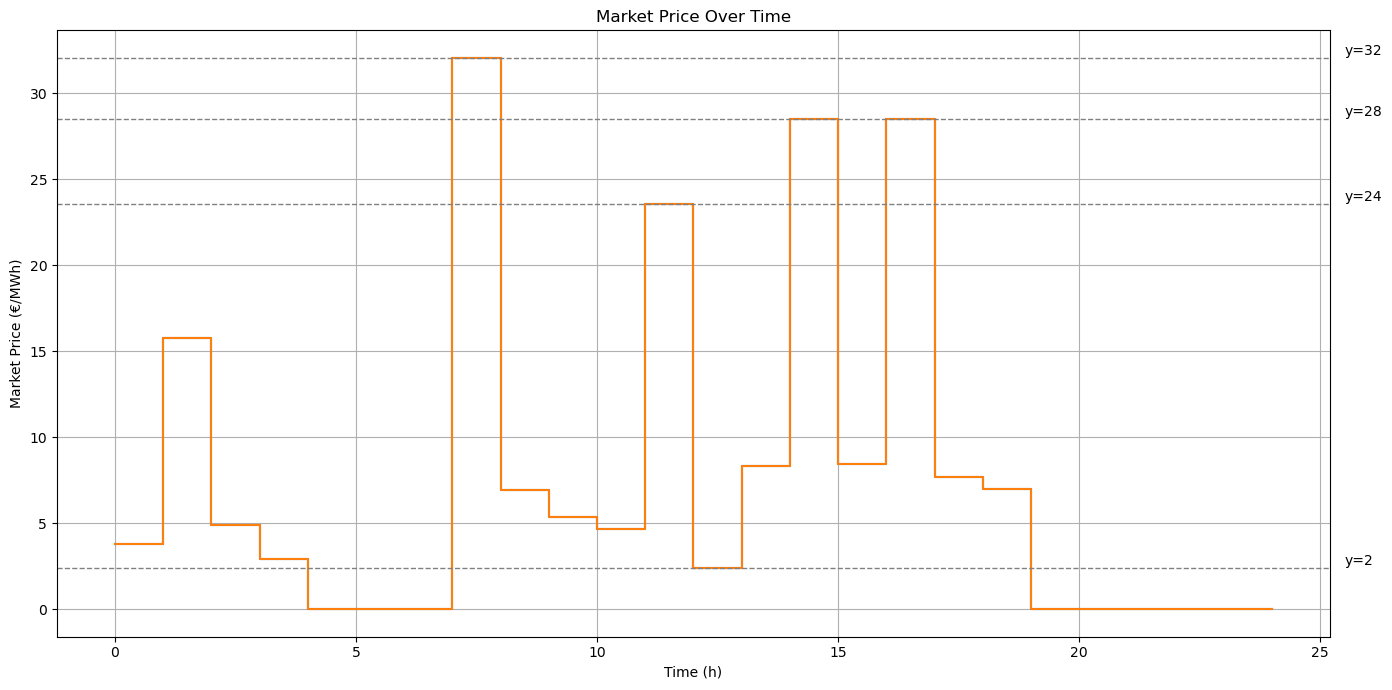

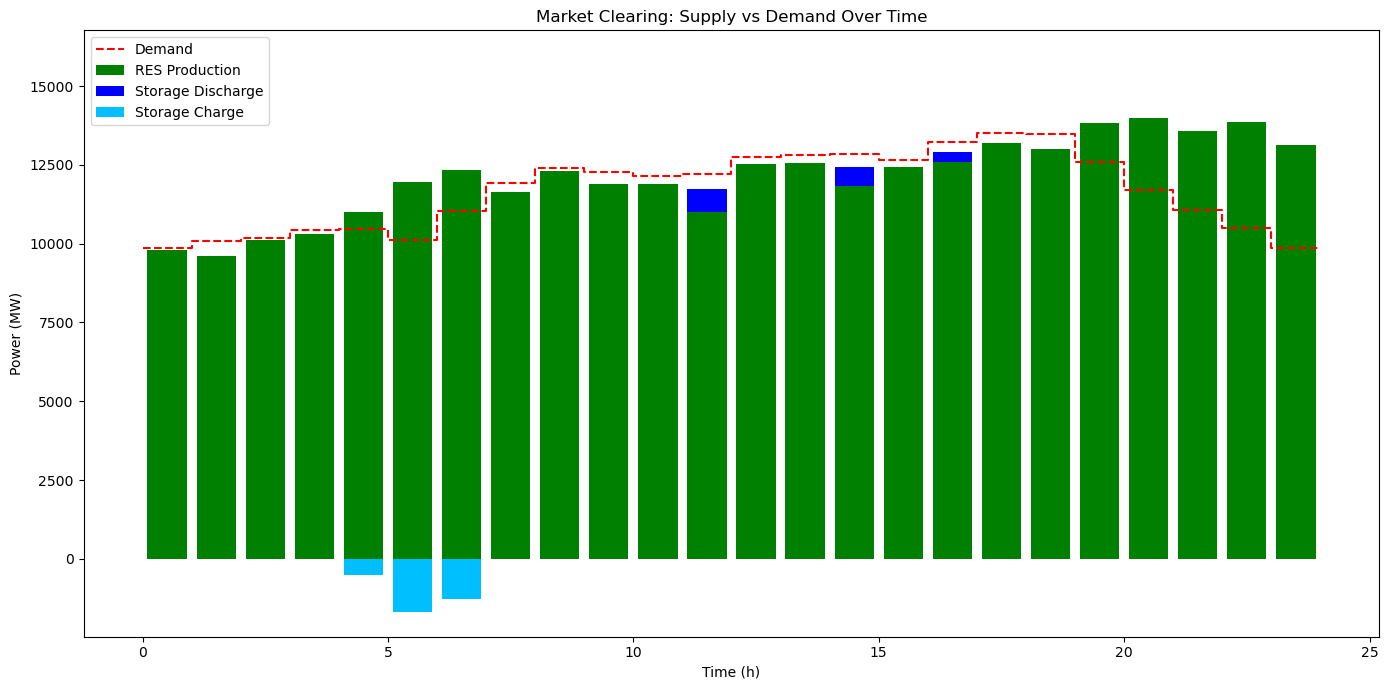

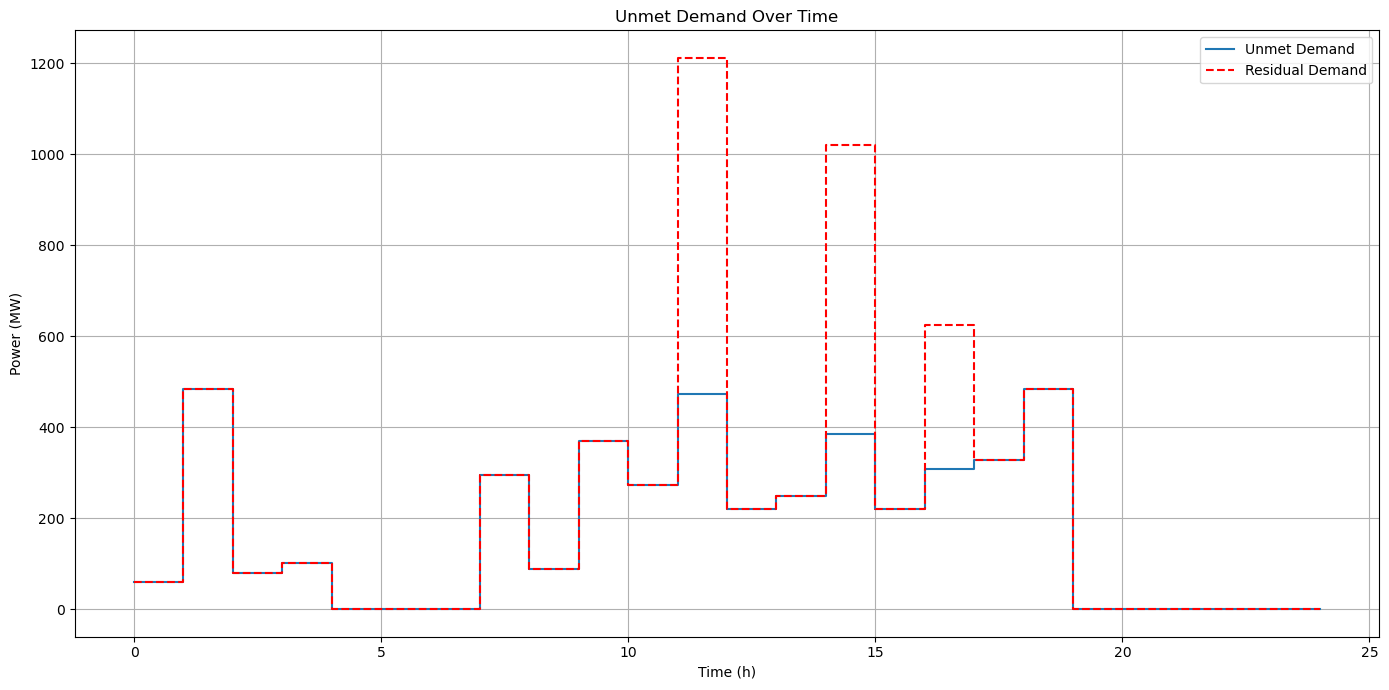

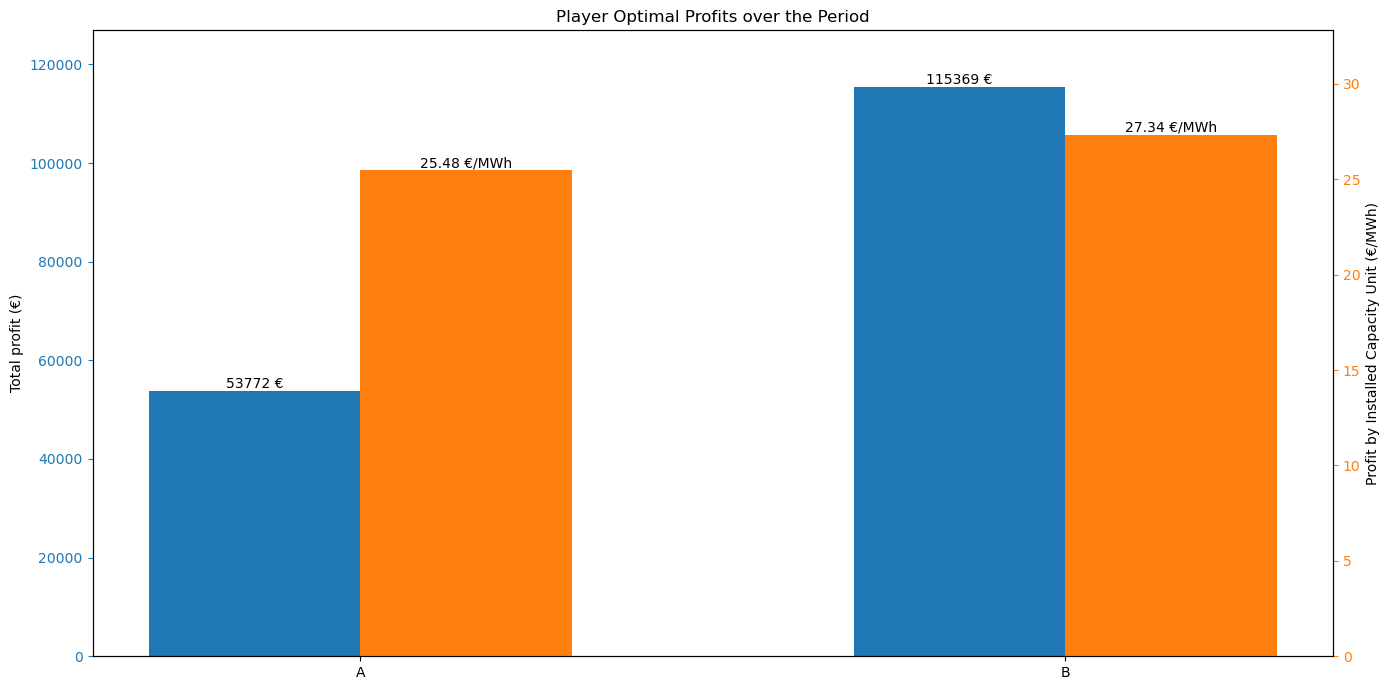

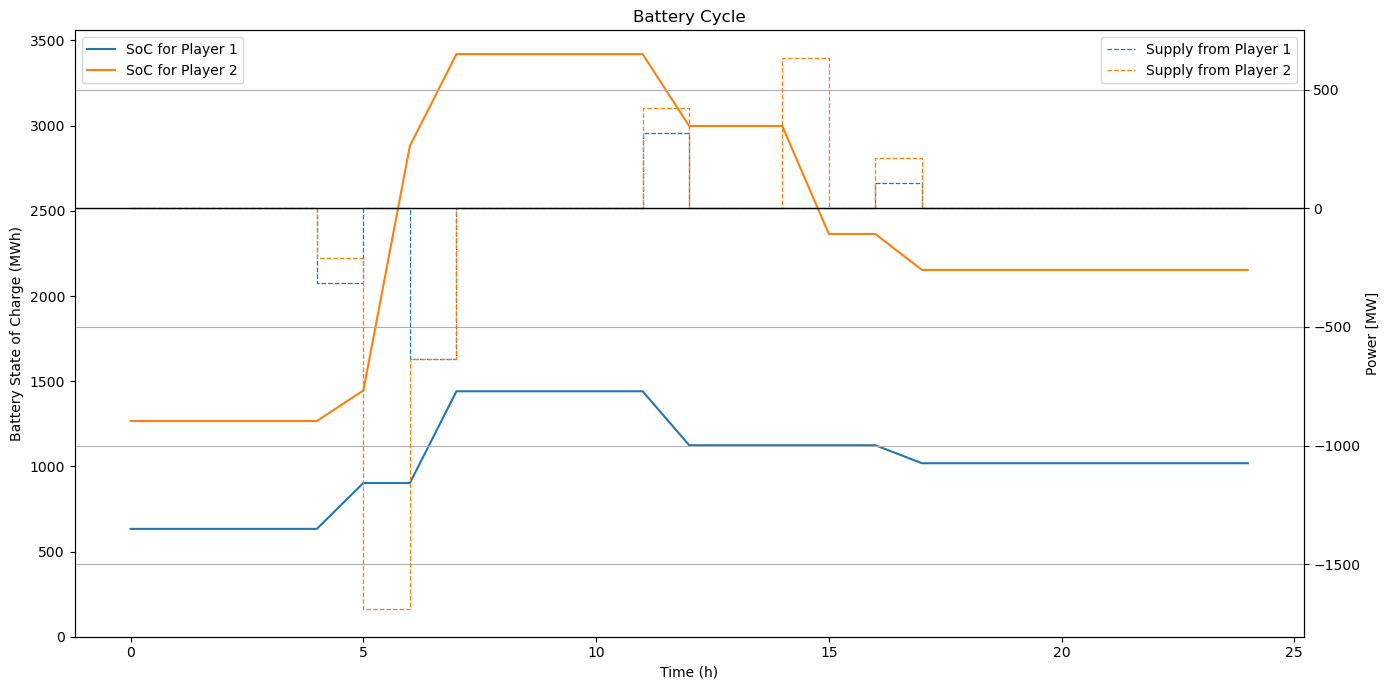

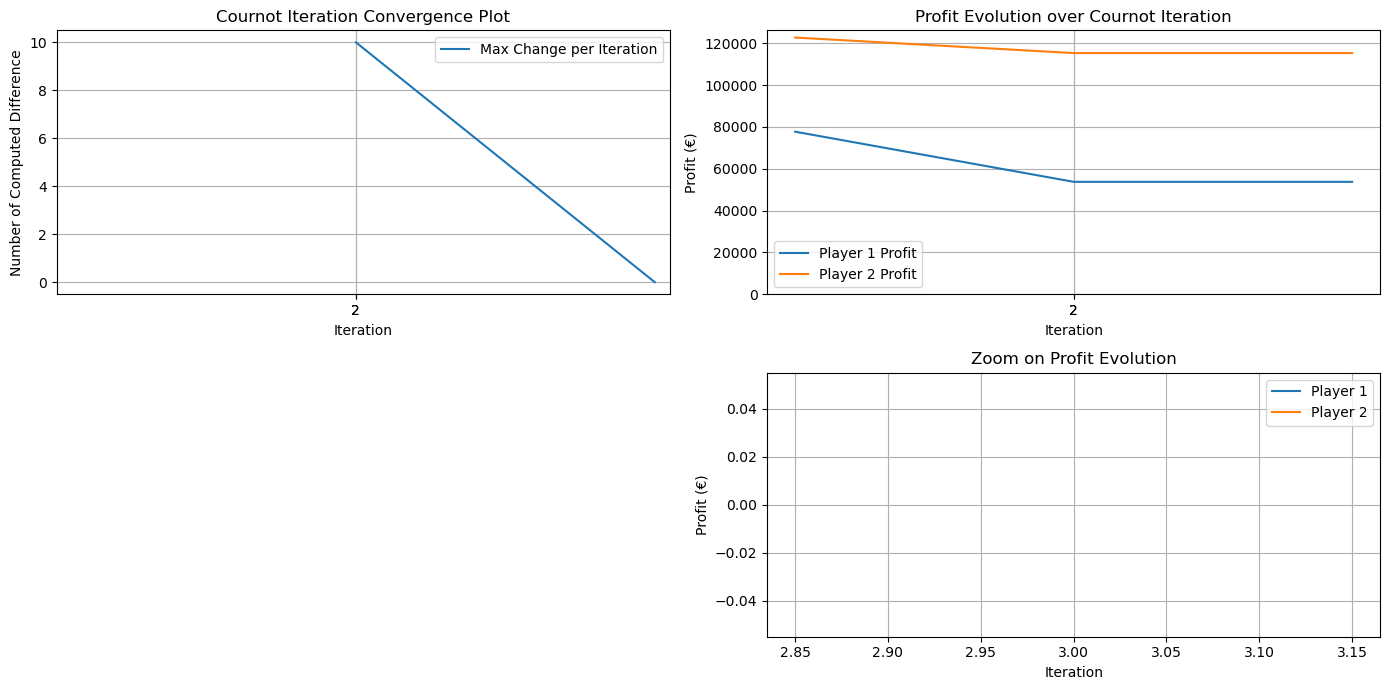

Running Winter - 2 players - With reserve policy: False
  Player   OC   Eta   E_max   Q_max  \
0      A  5.0  0.85  2110.0  1056.0   
1      B  5.0  0.85  4220.0  2112.0   

                                             Q_steps  
0  [0.0, 105.6, 211.2, 316.8, 422.4, 528.0, 633.6...  
1  [0.0, 211.2, 422.4, 633.6, 844.8, 1056.0, 1267...  
Optimization was successful. It converged in 4 iterations.


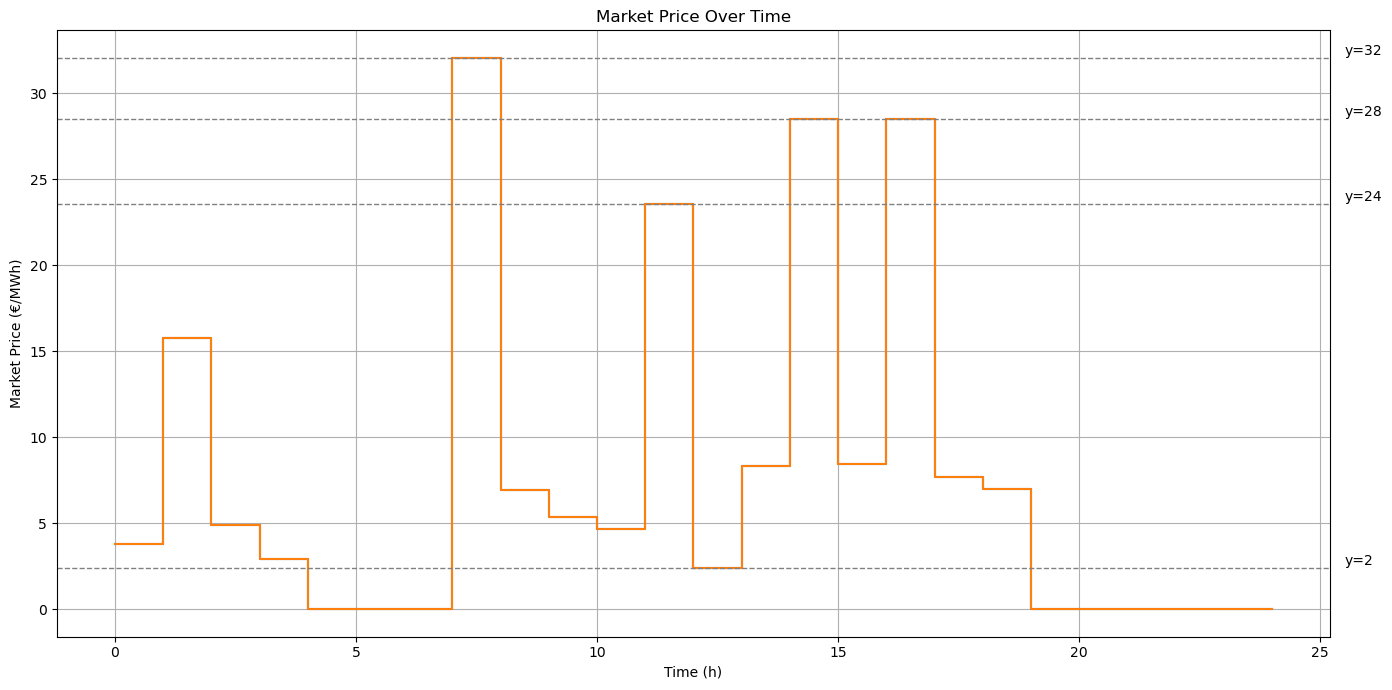

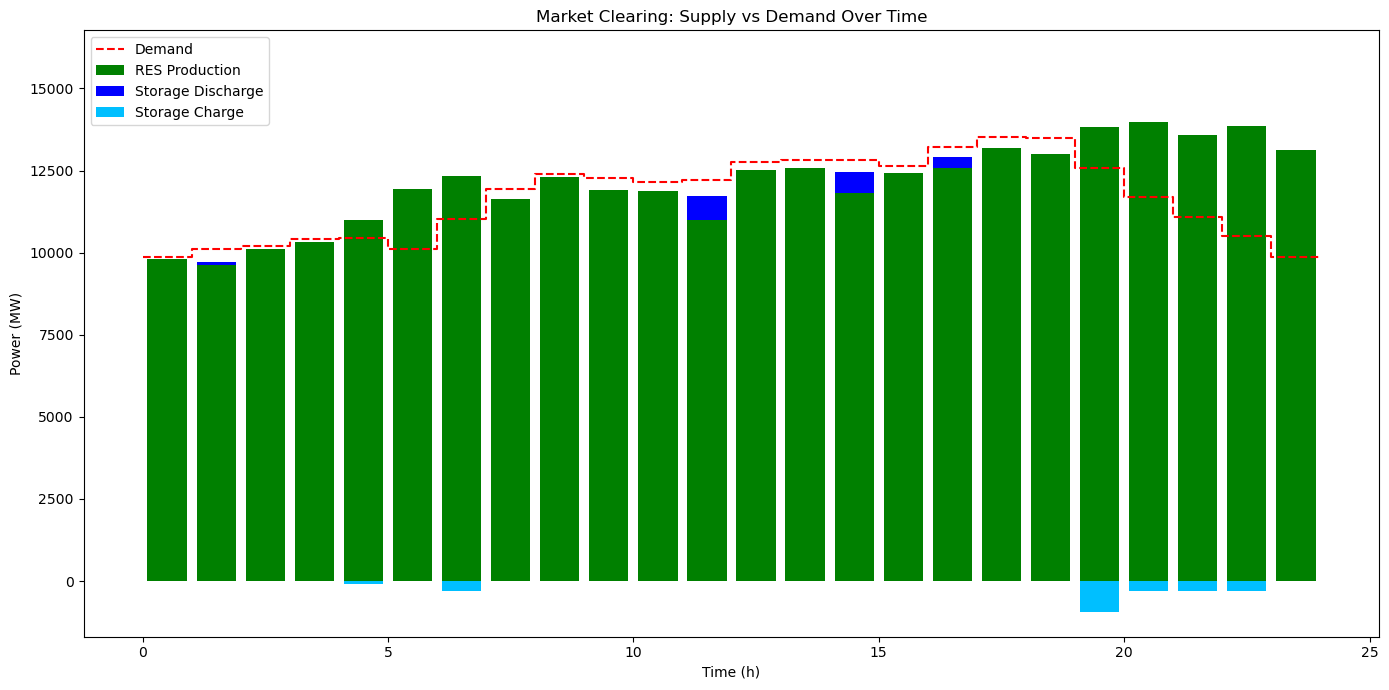

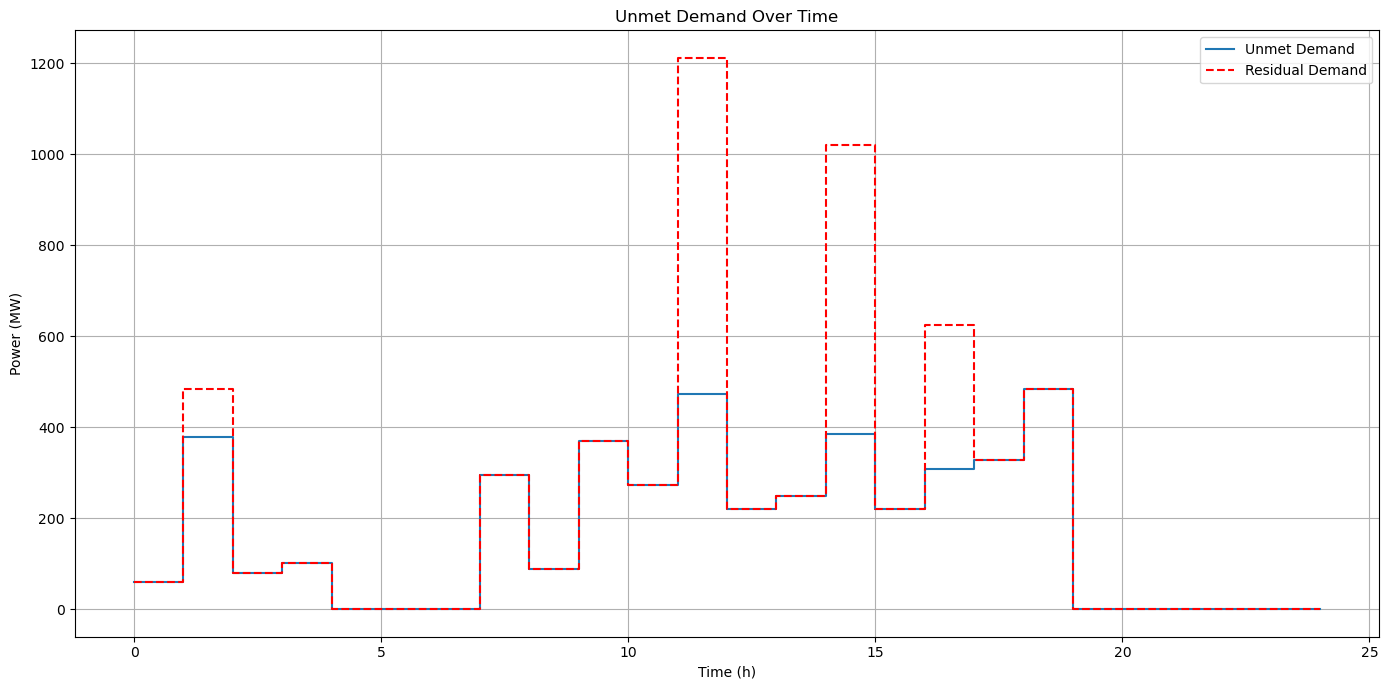

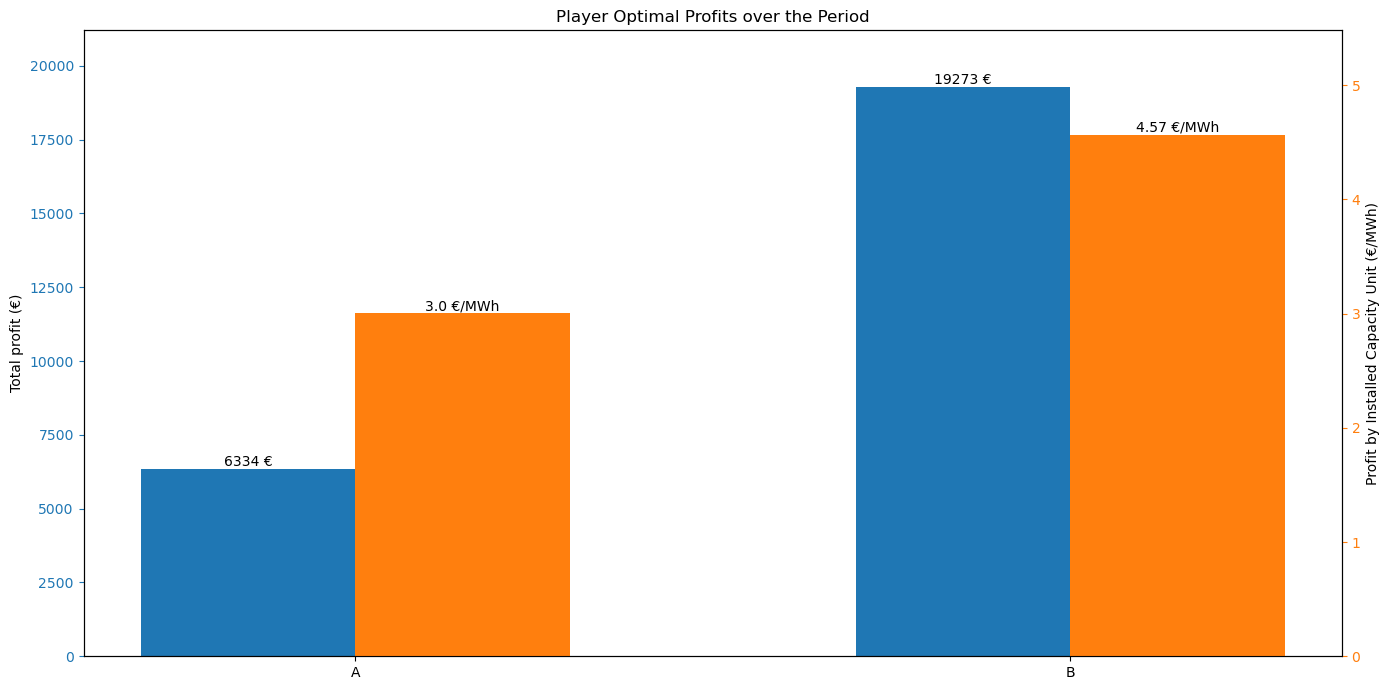

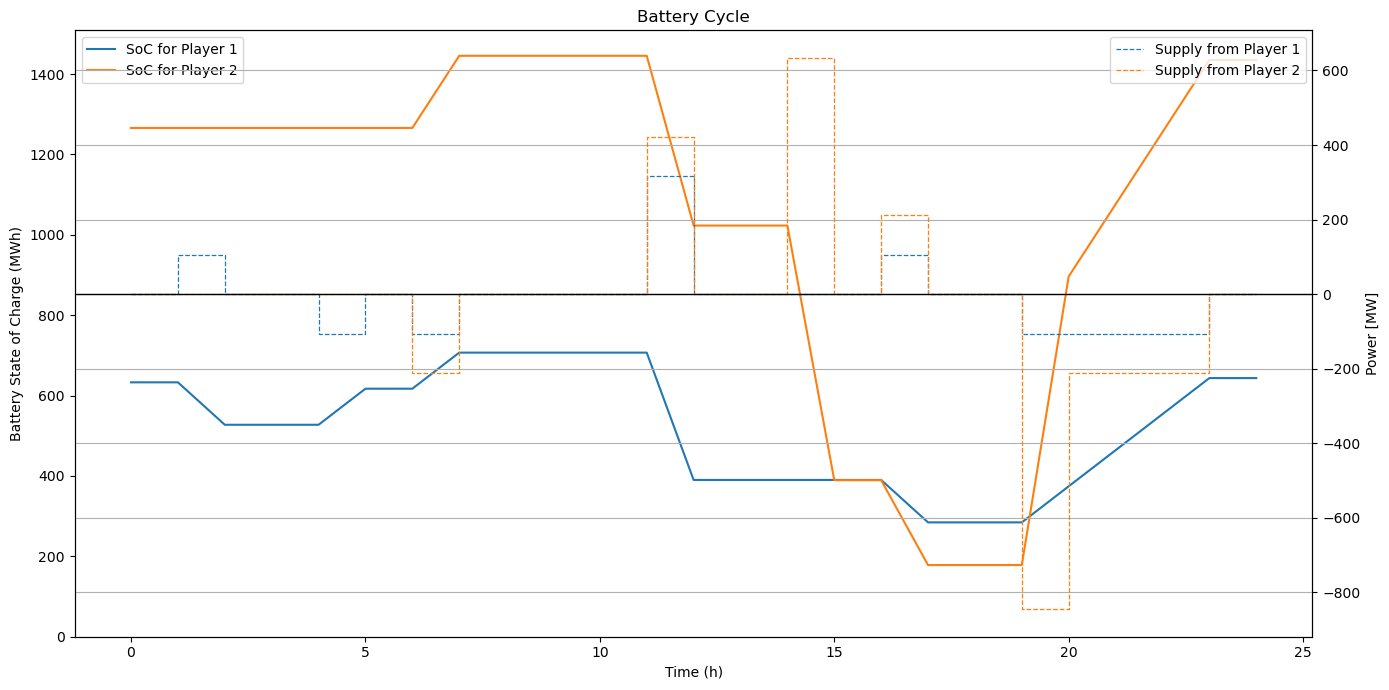

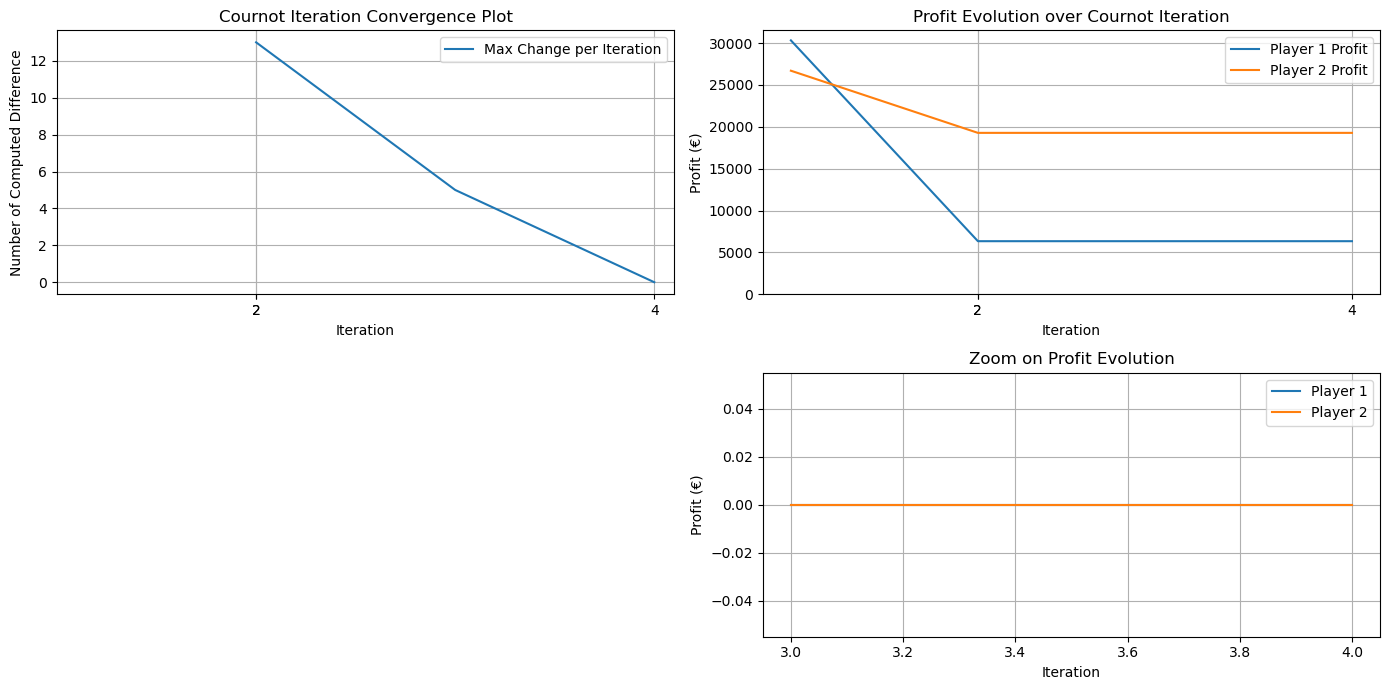

Running Summer - 2 players - With reserve policy: True
  Player   OC   Eta   E_max   Q_max  \
0      A  5.0  0.85  3840.0  1920.0   
1      B  5.0  0.85  7680.0  3840.0   

                                             Q_steps  
0  [0.0, 192.0, 384.0, 576.0, 768.0, 960.0, 1152....  
1  [0.0, 384.0, 768.0, 1152.0, 1536.0, 1920.0, 23...  
Convergence has not been reached. Let's try again by fixing player A outputs.
Optimization was successful. It converged in 201 iterations.


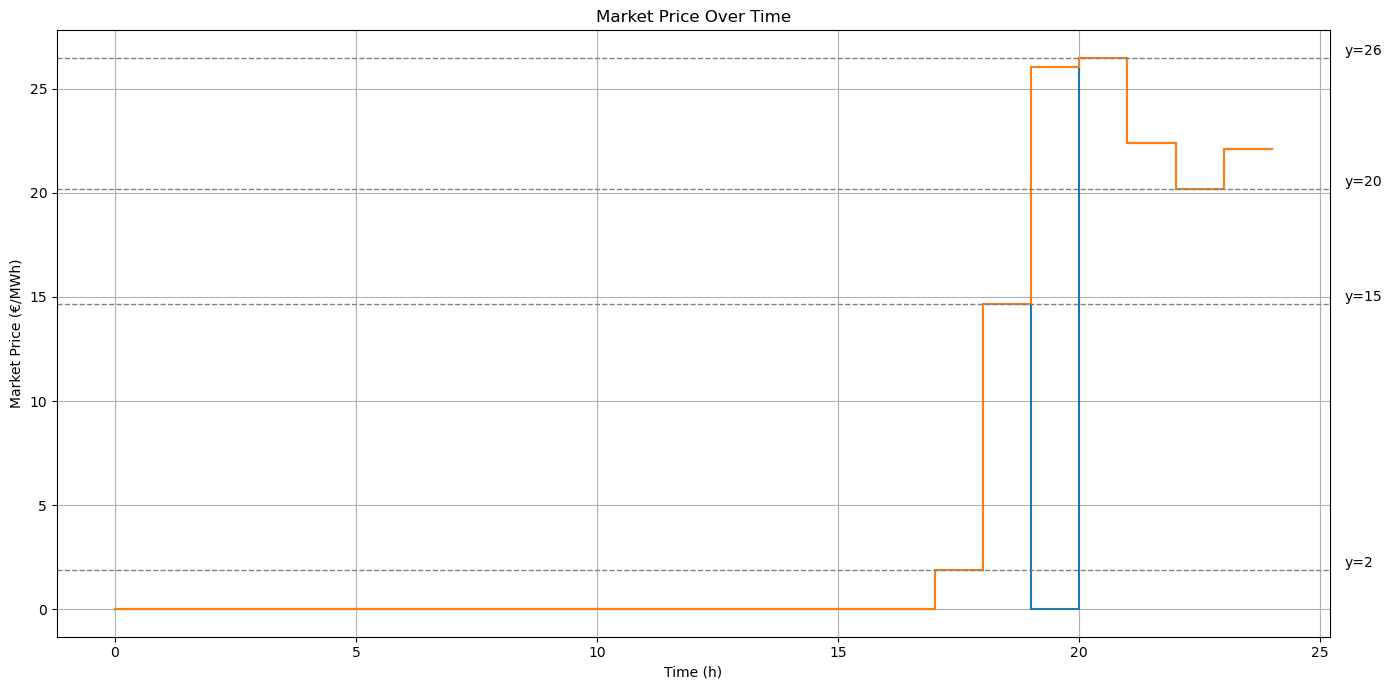

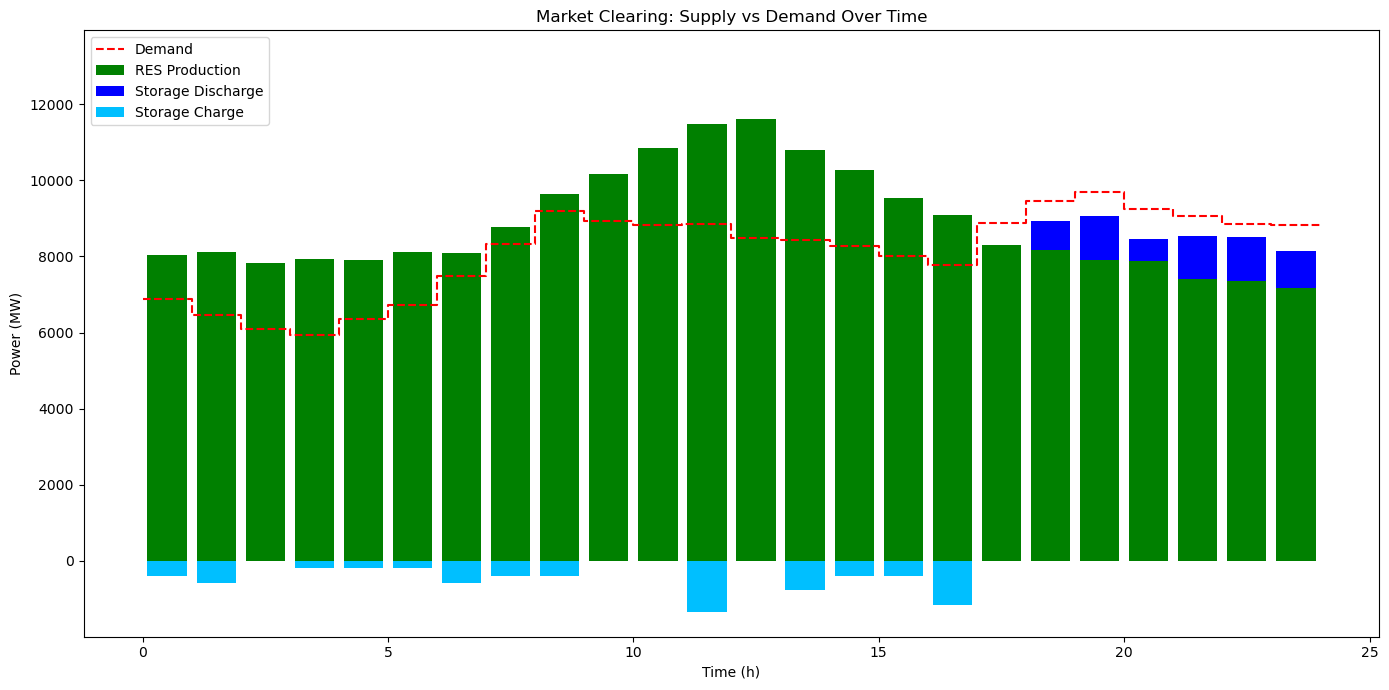

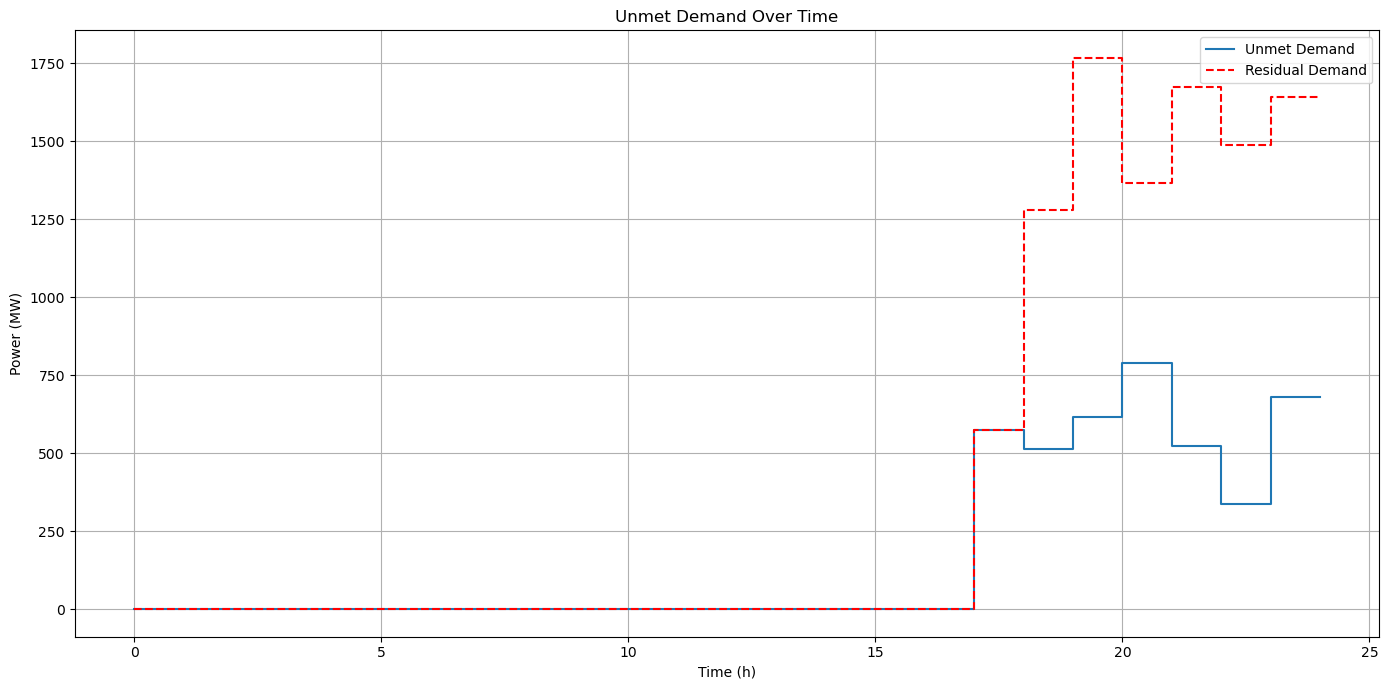

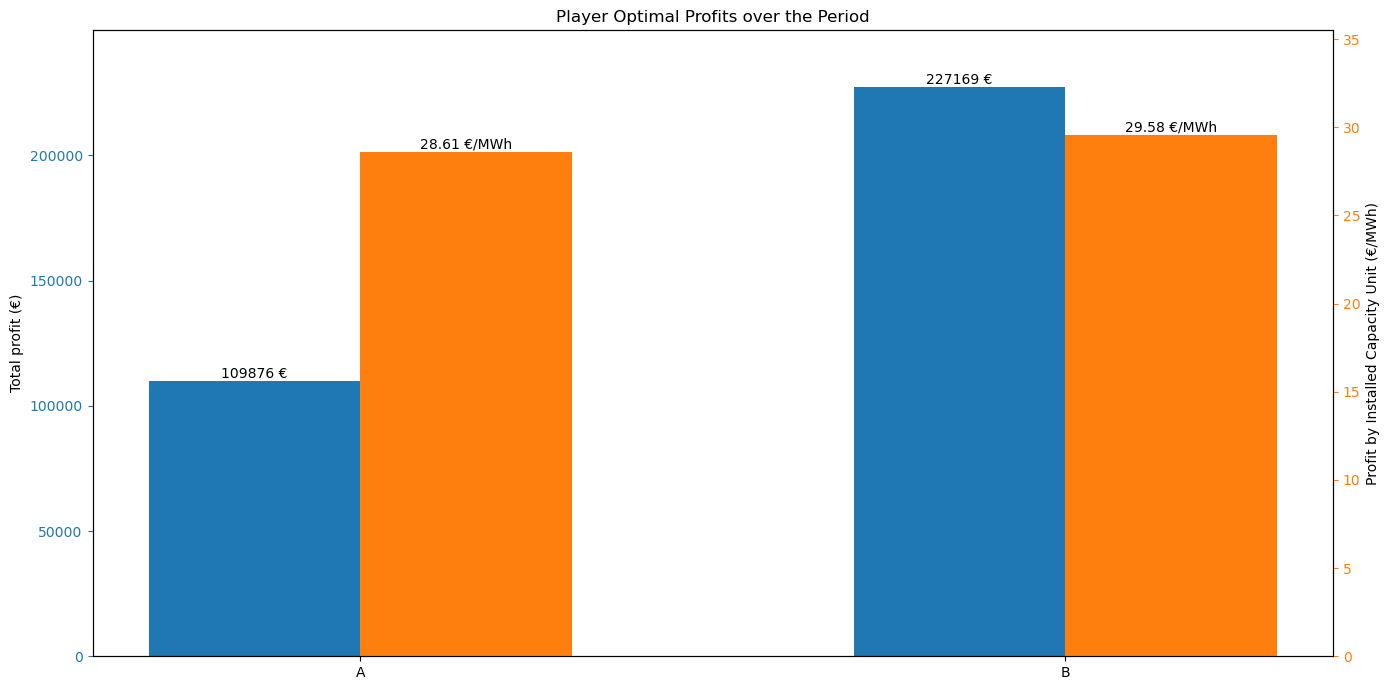

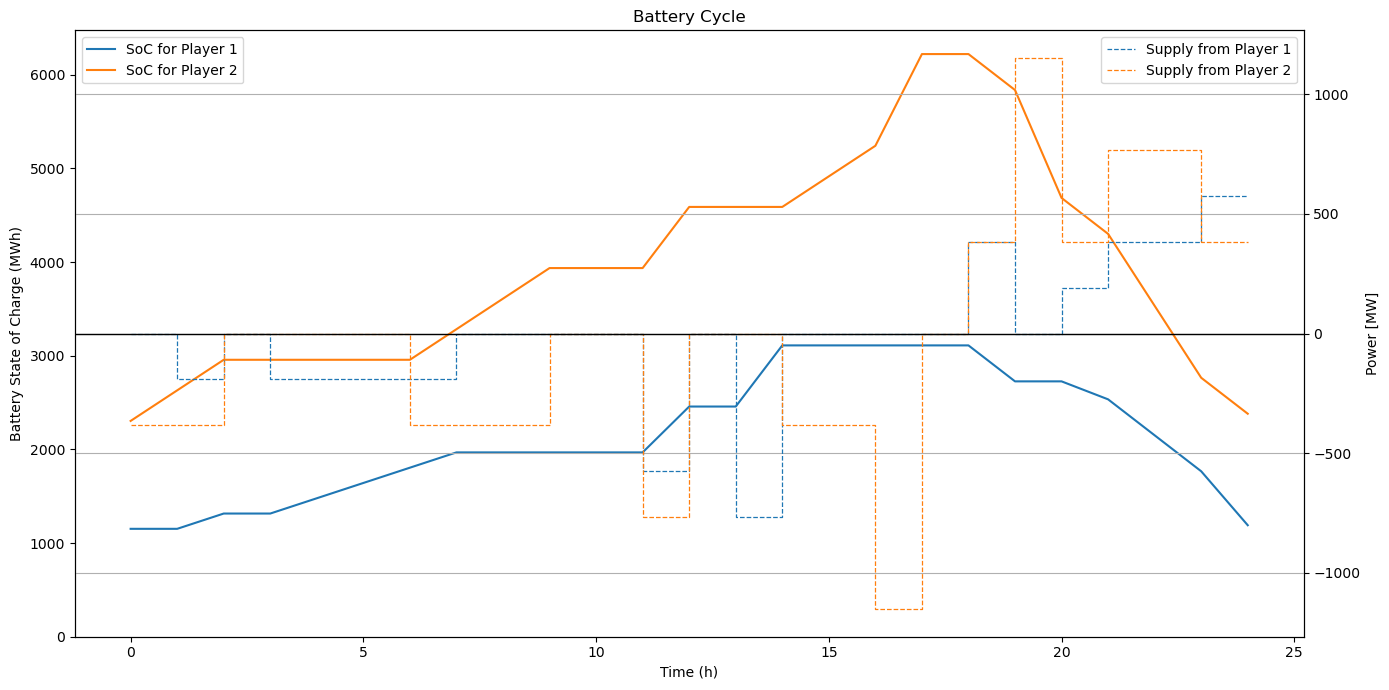

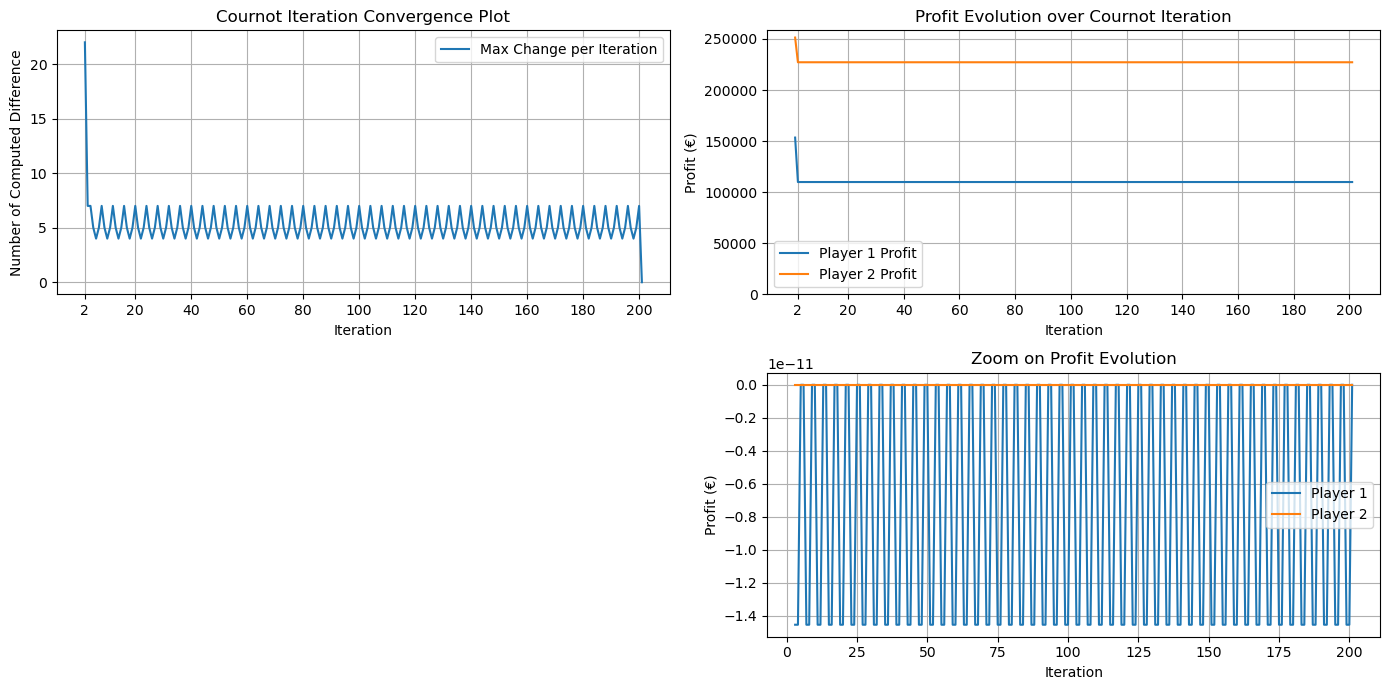

Running Summer - 2 players - With reserve policy: False
  Player   OC   Eta   E_max   Q_max  \
0      A  5.0  0.85  3840.0  1920.0   
1      B  5.0  0.85  7680.0  3840.0   

                                             Q_steps  
0  [0.0, 192.0, 384.0, 576.0, 768.0, 960.0, 1152....  
1  [0.0, 384.0, 768.0, 1152.0, 1536.0, 1920.0, 23...  
Optimization was successful. It converged in 8 iterations.


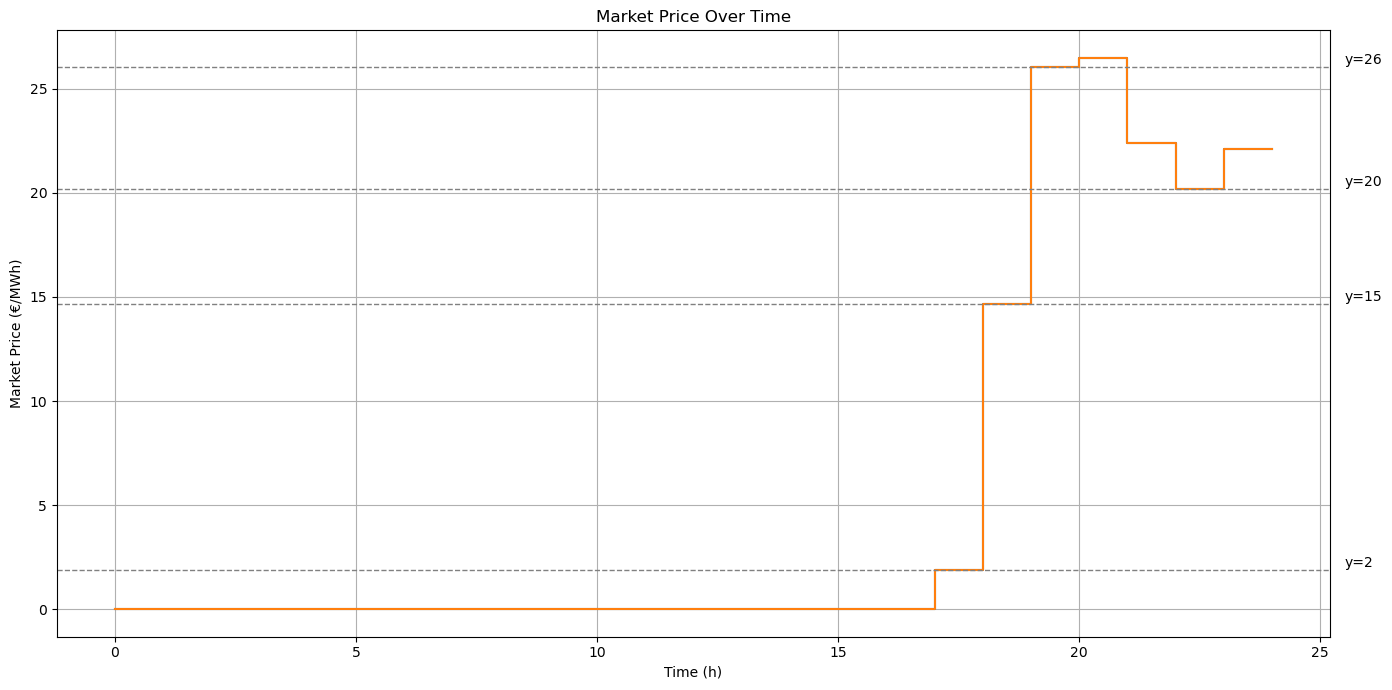

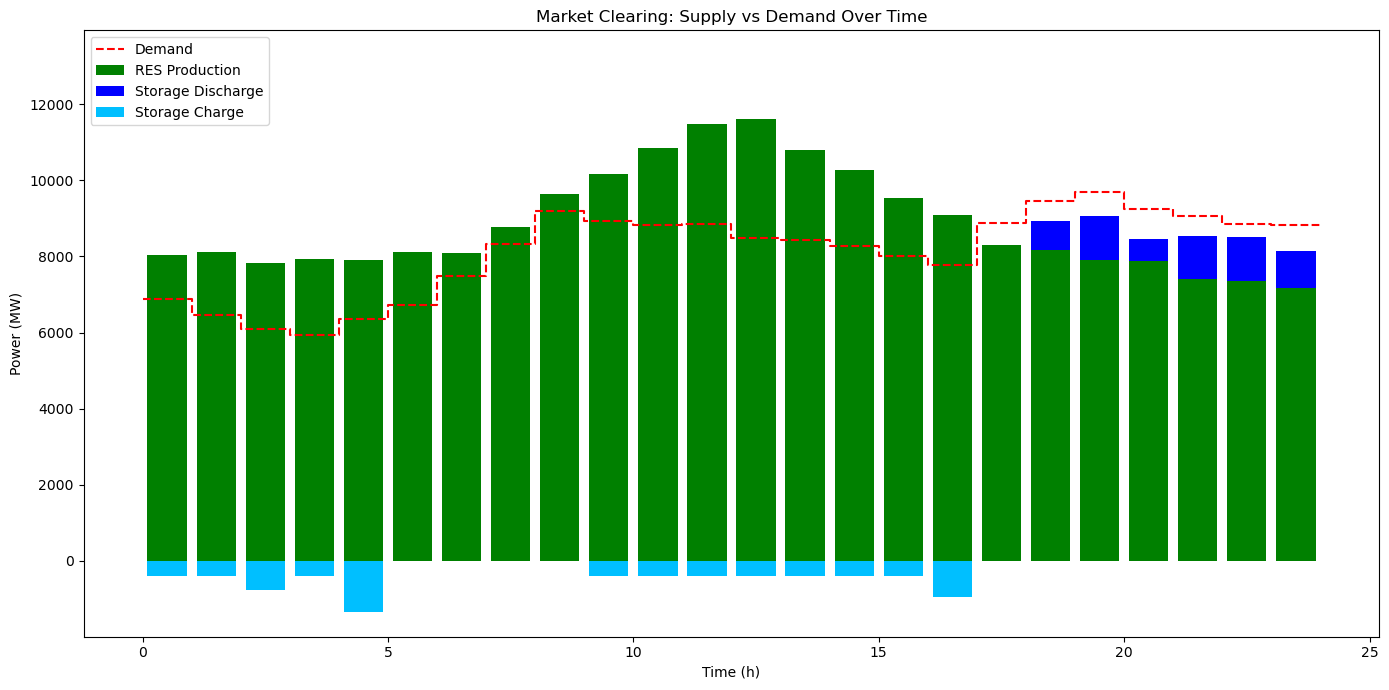

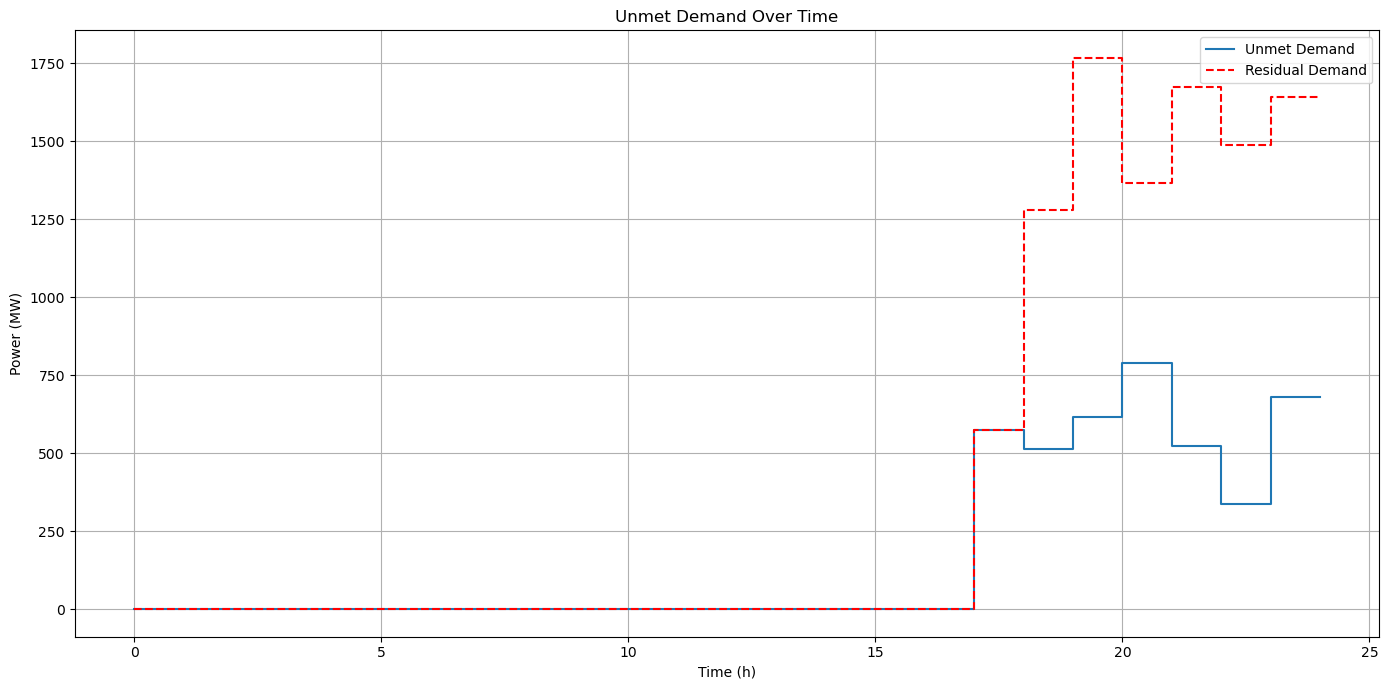

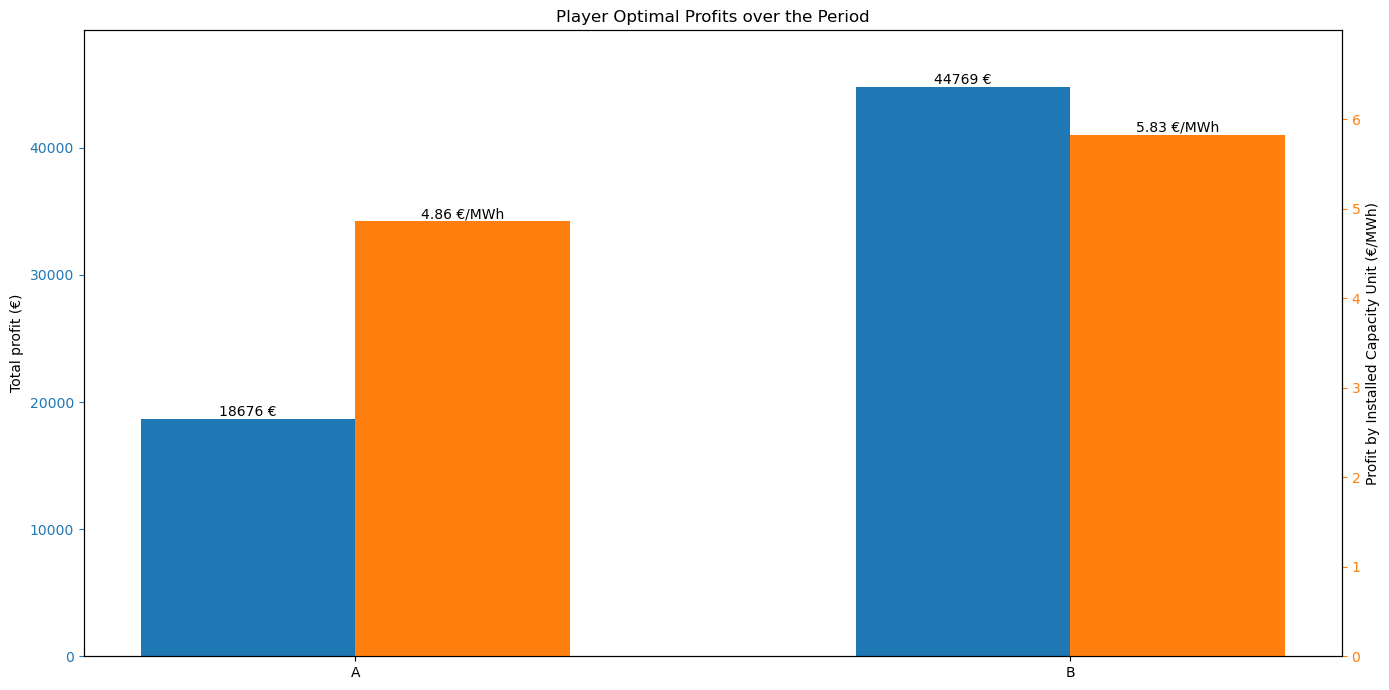

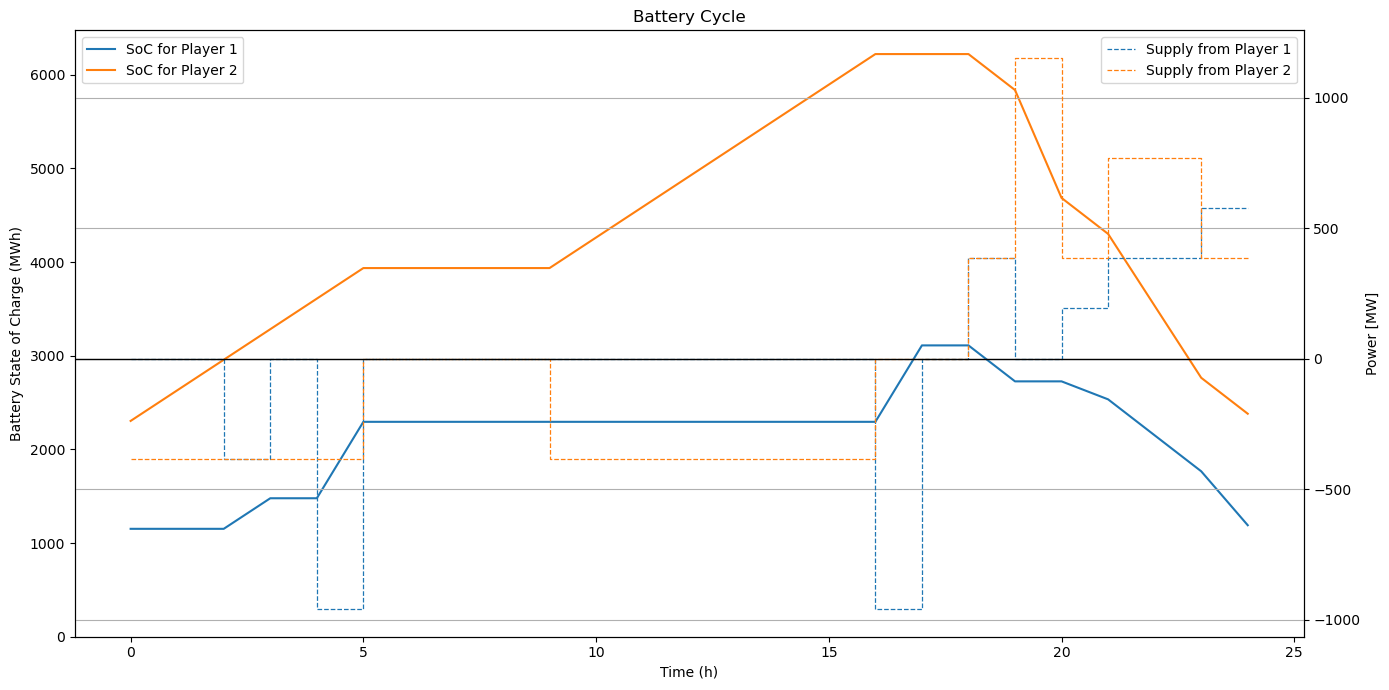

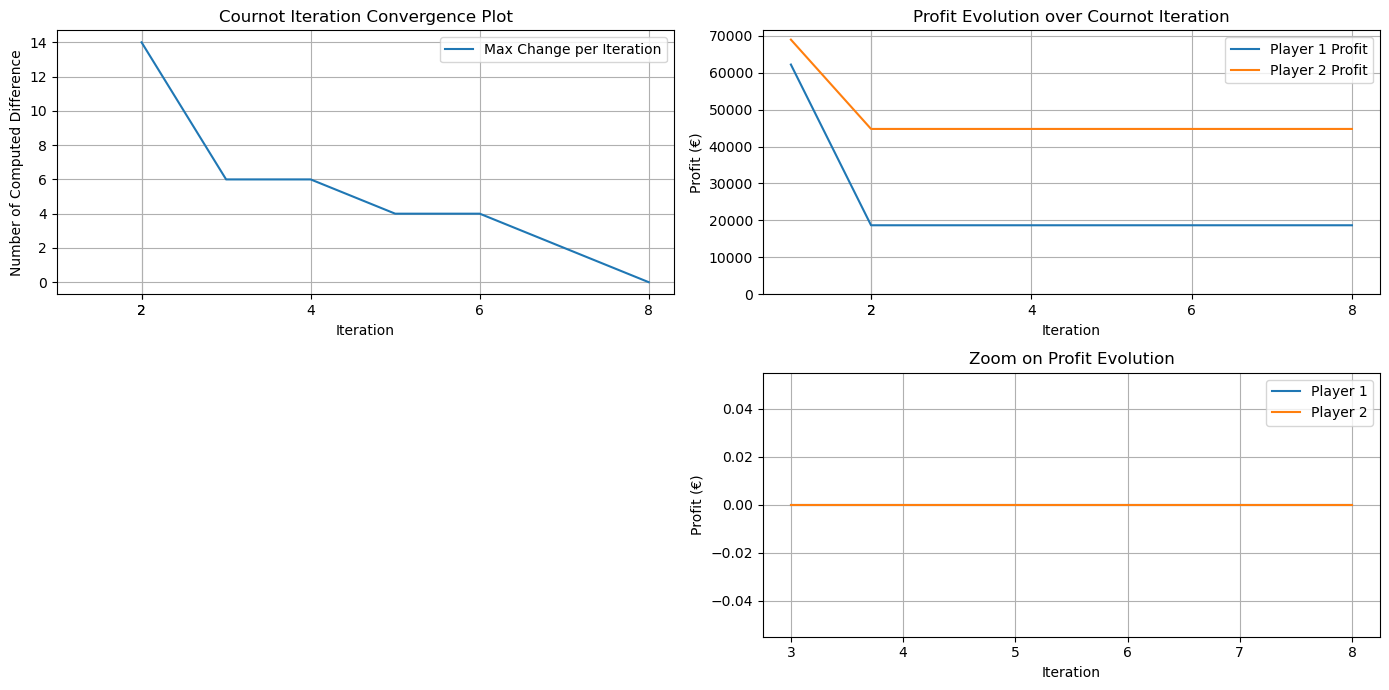

Running LowLoad - 2 players - With reserve policy: True
  Player   OC   Eta   E_max   Q_max  \
0      A  5.0  0.85  3040.0  1523.0   
1      B  5.0  0.85  6090.0  3047.0   

                                             Q_steps  
0  [0.0, 152.3, 304.6, 456.9, 609.2, 761.5, 913.8...  
1  [0.0, 304.7, 609.4, 914.1, 1218.8, 1523.5, 182...  
Optimization was successful. It converged in 7 iterations.


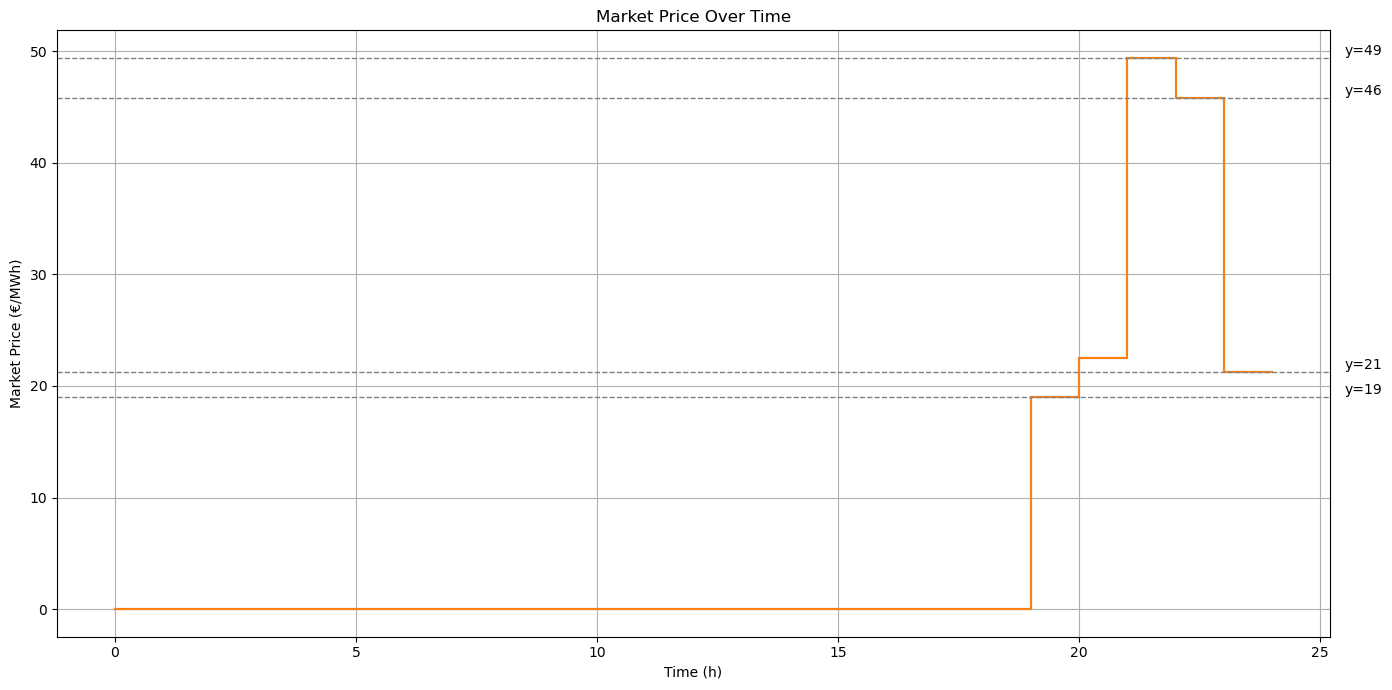

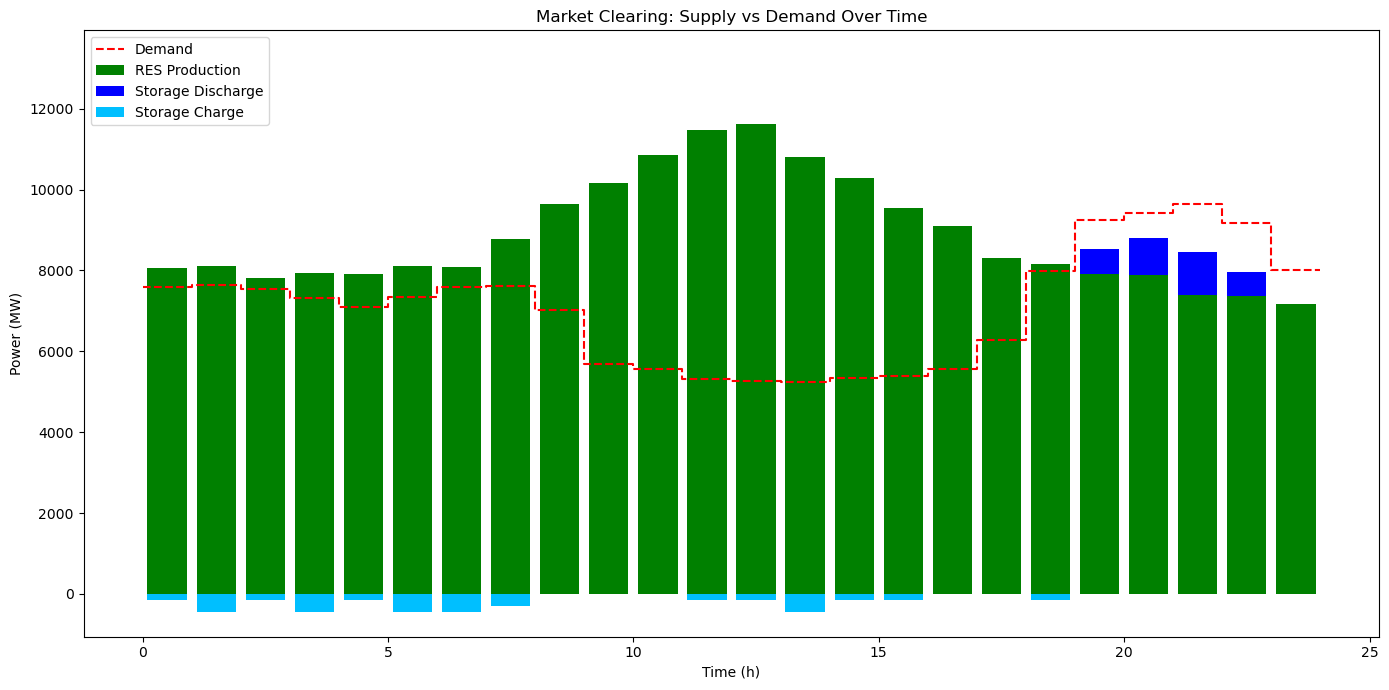

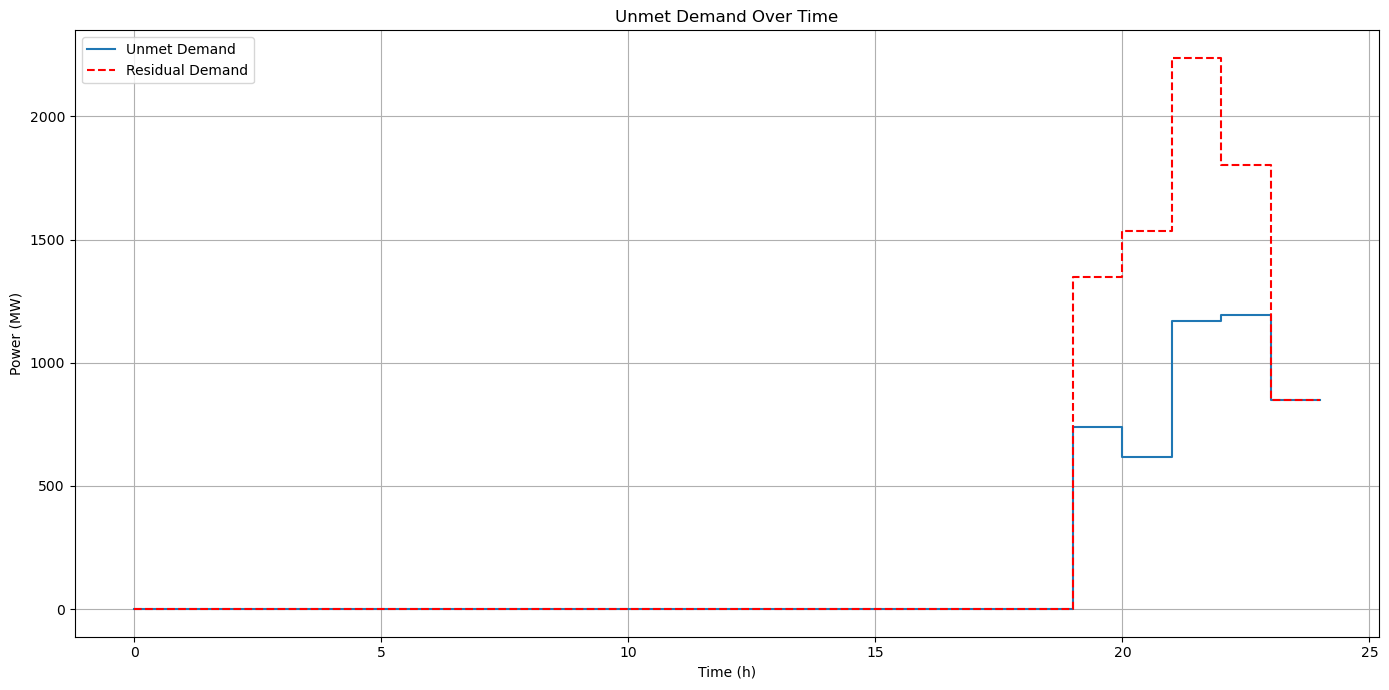

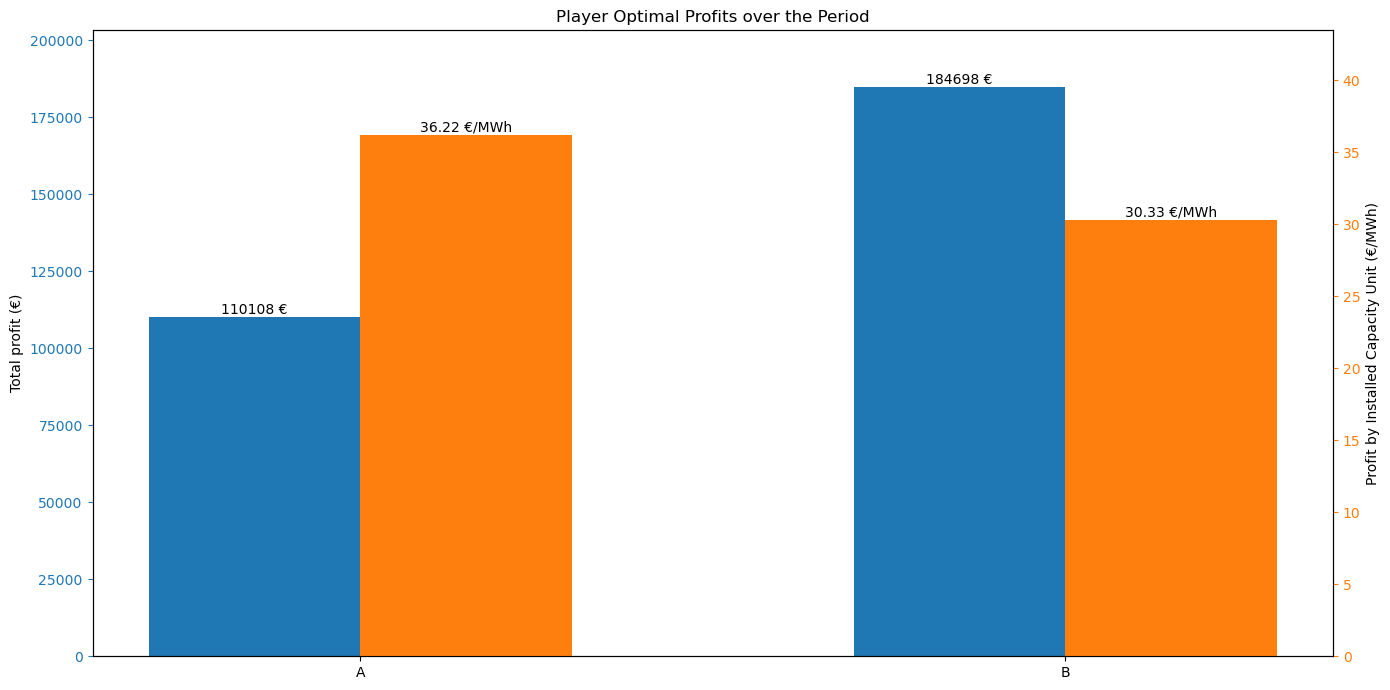

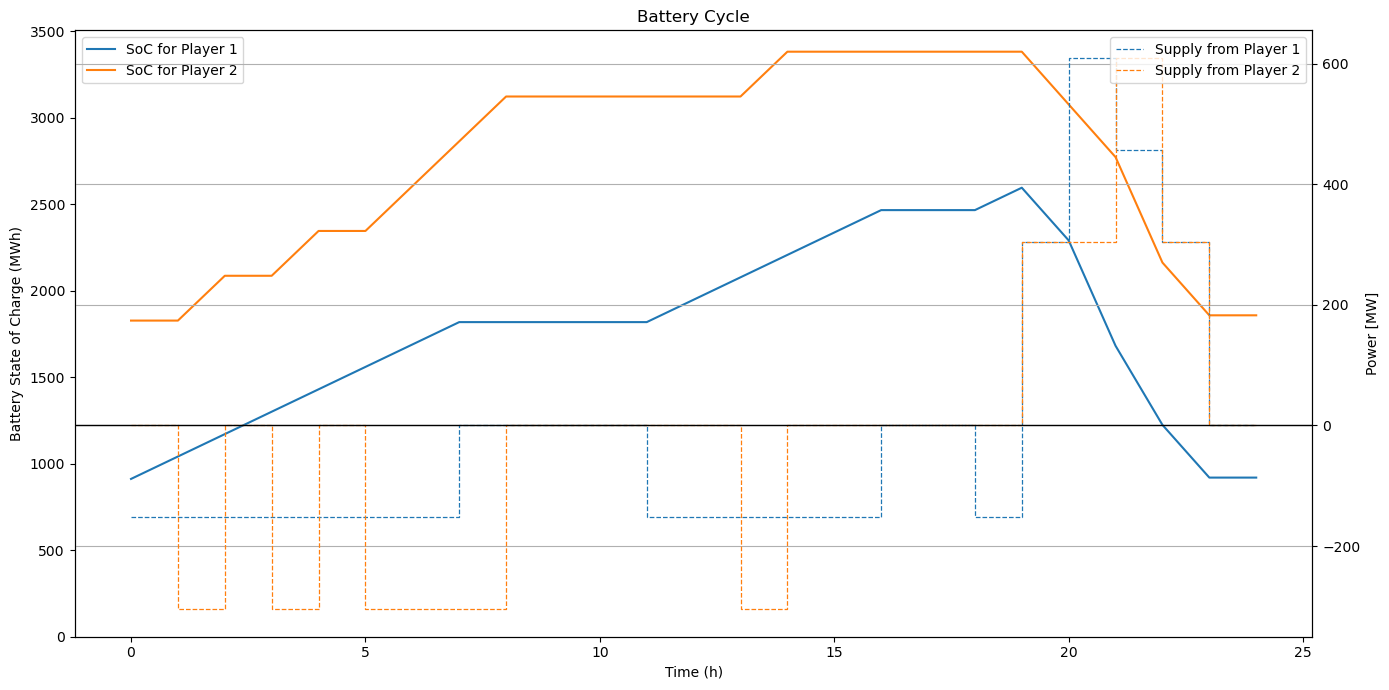

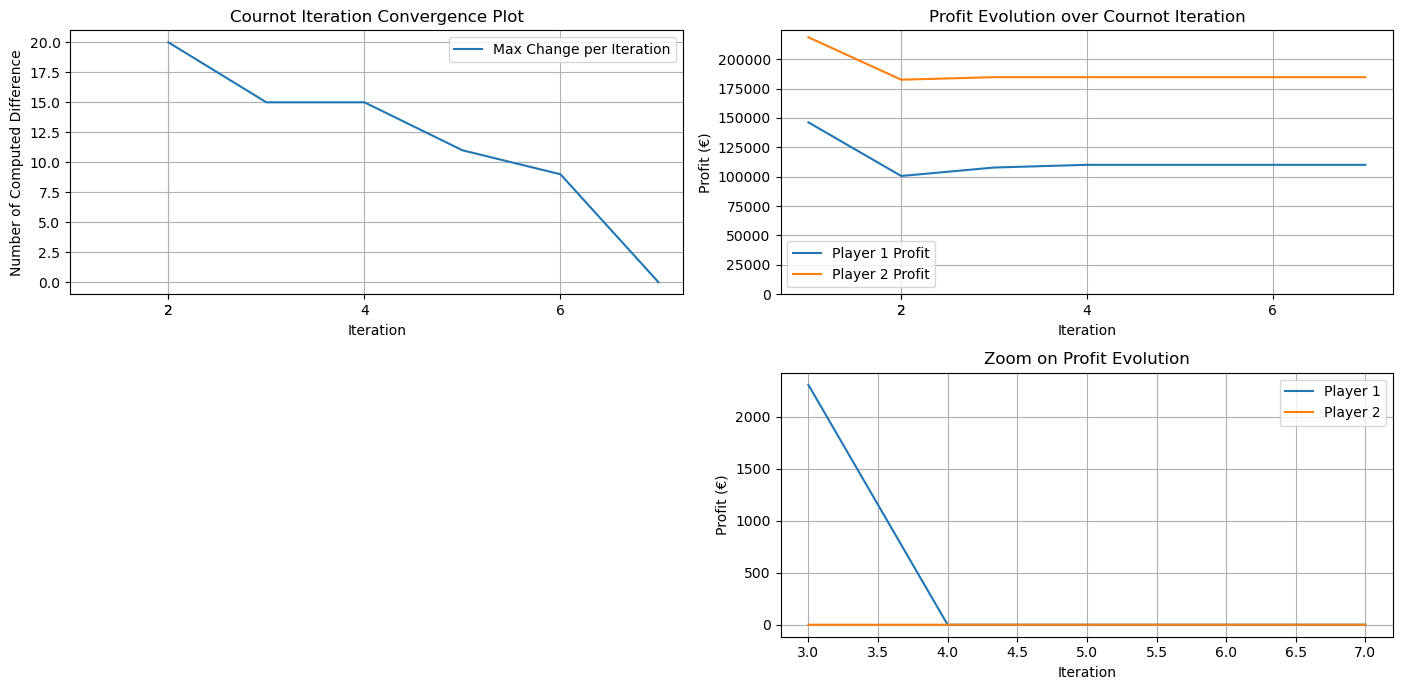

Running LowLoad - 2 players - With reserve policy: False
  Player   OC   Eta   E_max   Q_max  \
0      A  5.0  0.85  3040.0  1523.0   
1      B  5.0  0.85  6090.0  3047.0   

                                             Q_steps  
0  [0.0, 152.3, 304.6, 456.9, 609.2, 761.5, 913.8...  
1  [0.0, 304.7, 609.4, 914.1, 1218.8, 1523.5, 182...  
Convergence has not been reached. Let's try again by fixing player A outputs.
Optimization was successful. It converged in 201 iterations.


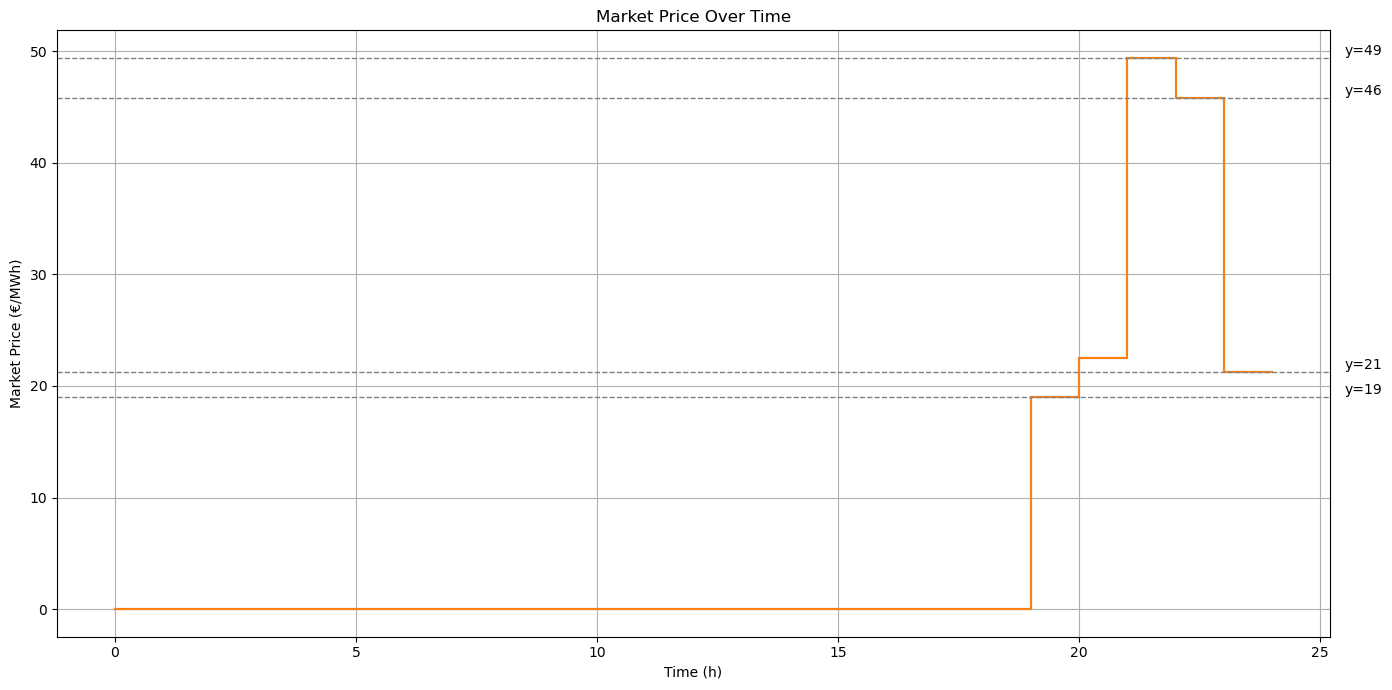

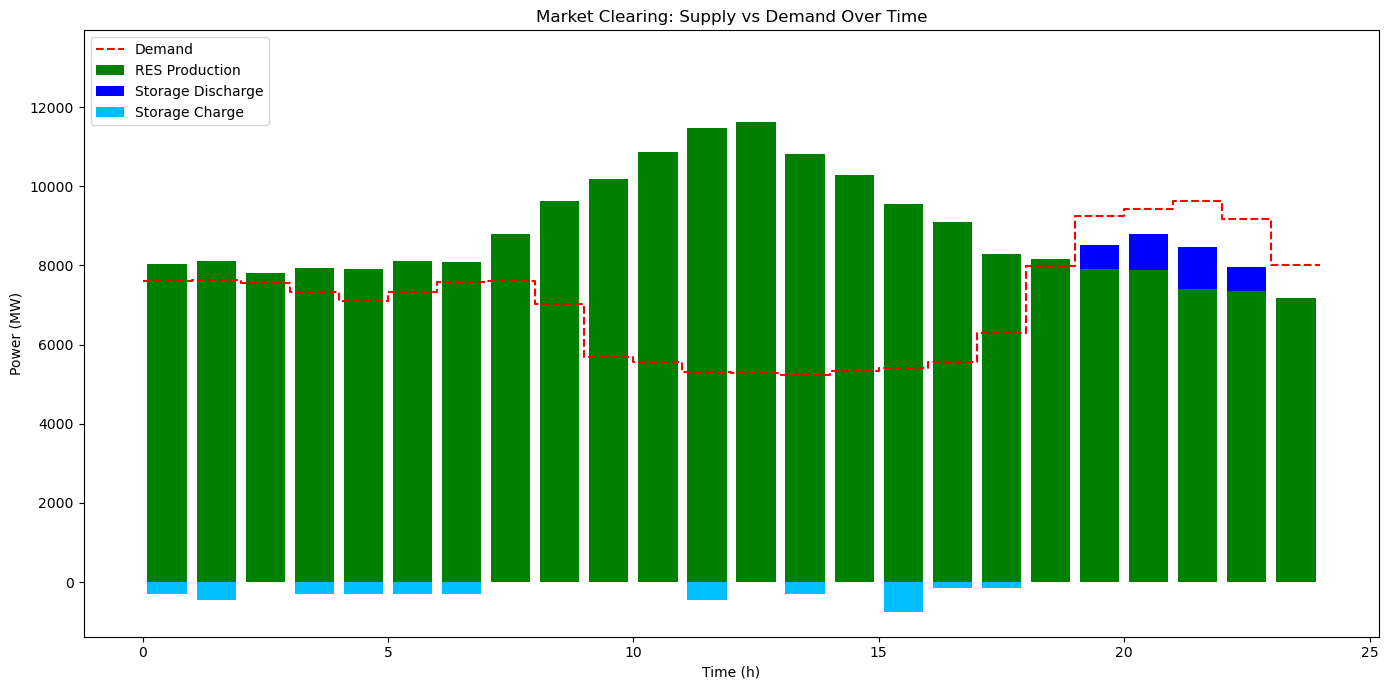

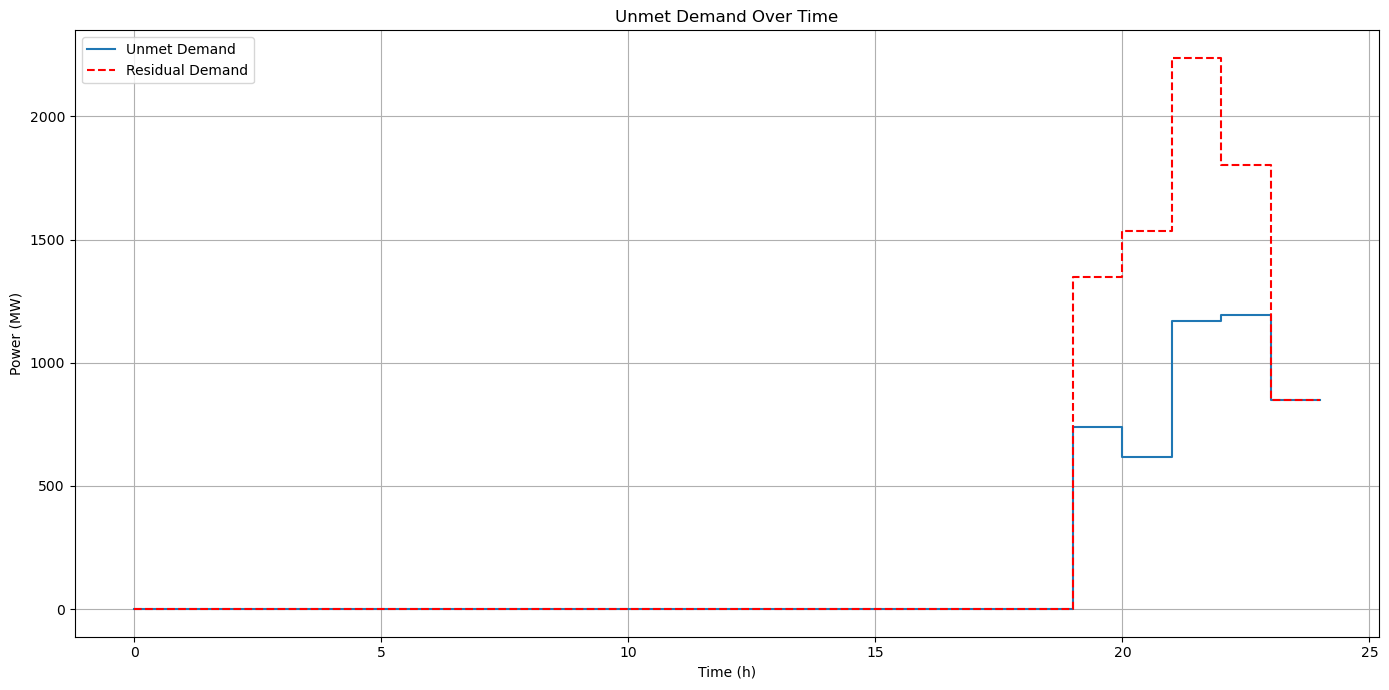

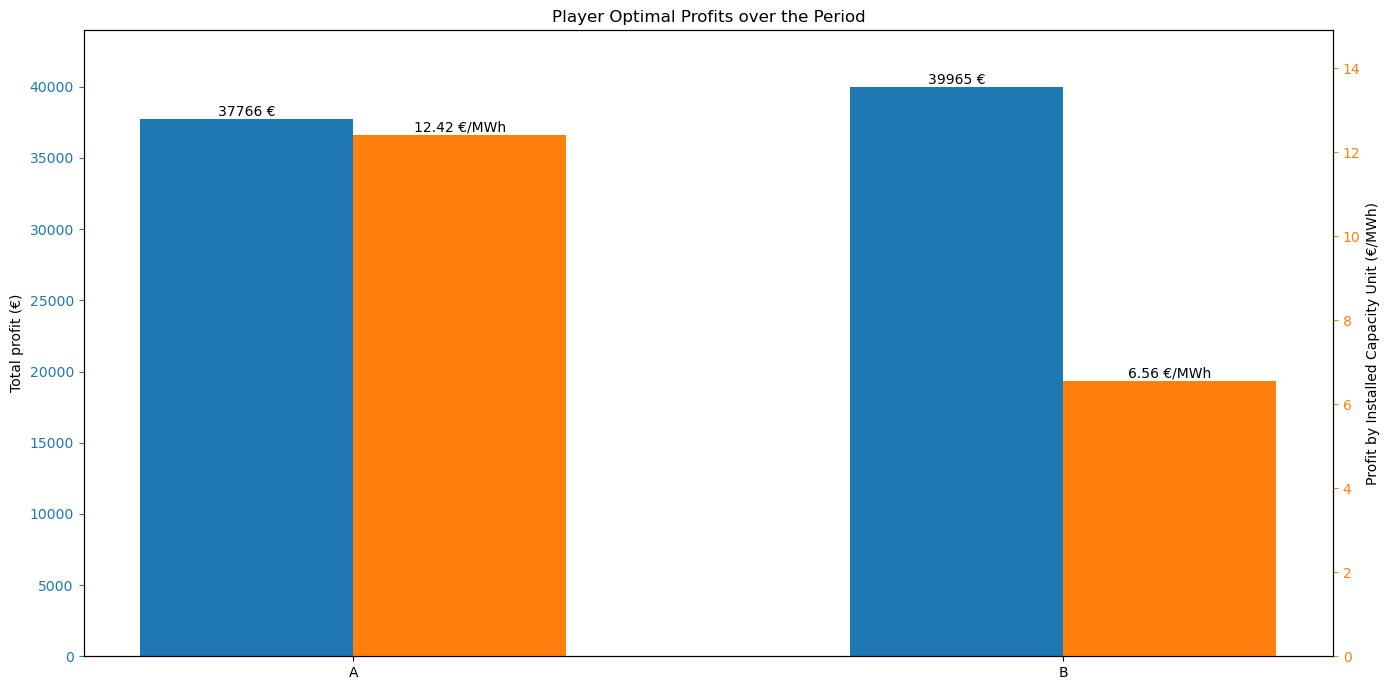

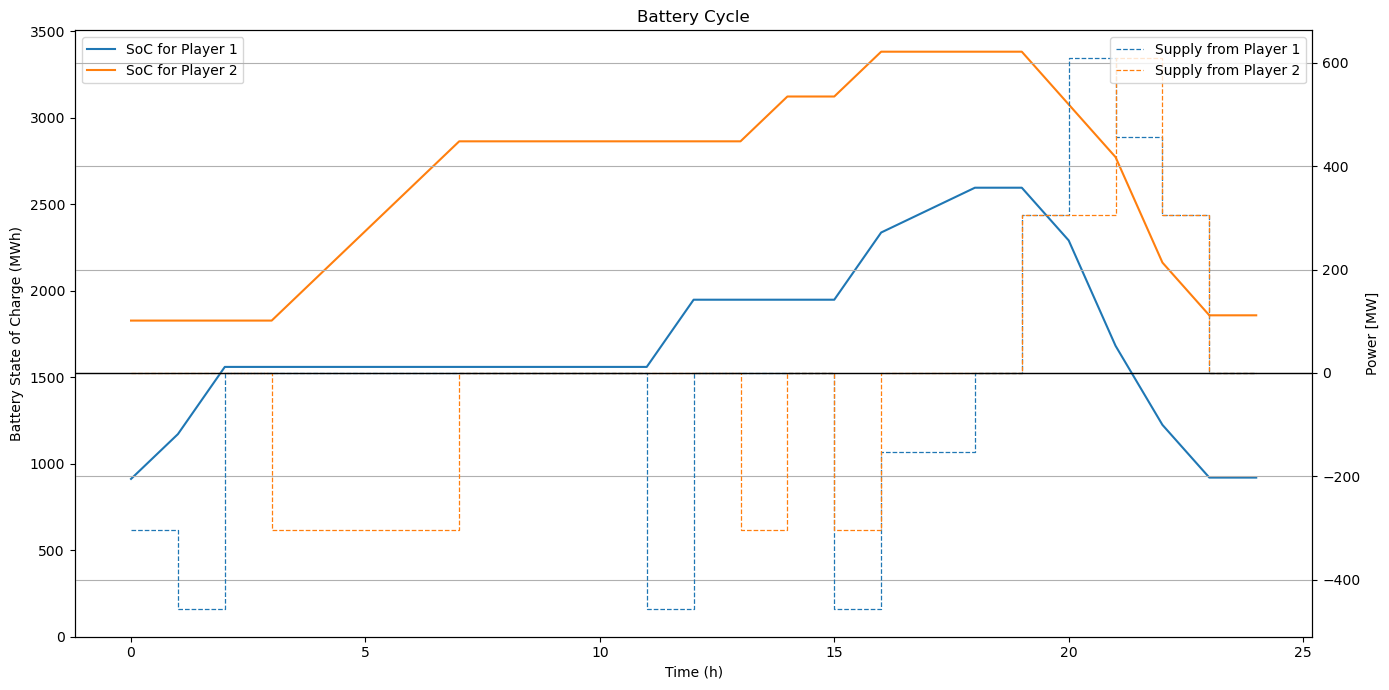

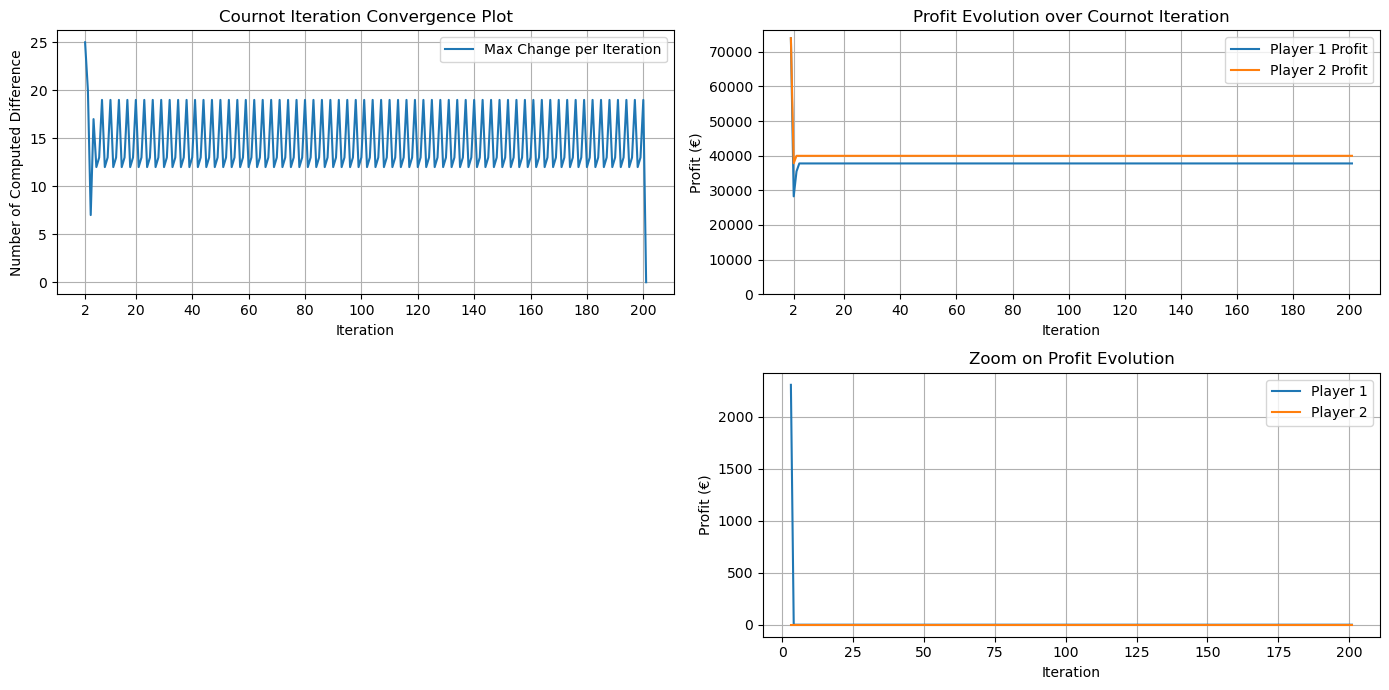

In [10]:
# Run the model with reserve policy
results_reserve = {}

for season in seasons:
    results_reserve[season] = {}
    for with_policy in [True, False]:
        print(f"Running {season} - 2 players - With reserve policy: {with_policy}")
        output = main(season=season, n_players=2, alpha_batt=0.3, save_plots=SAVE_FIGS, policy_parameters=reserve_policy_parameters, reserve_policy=with_policy)
        results_reserve[season][with_policy] = output

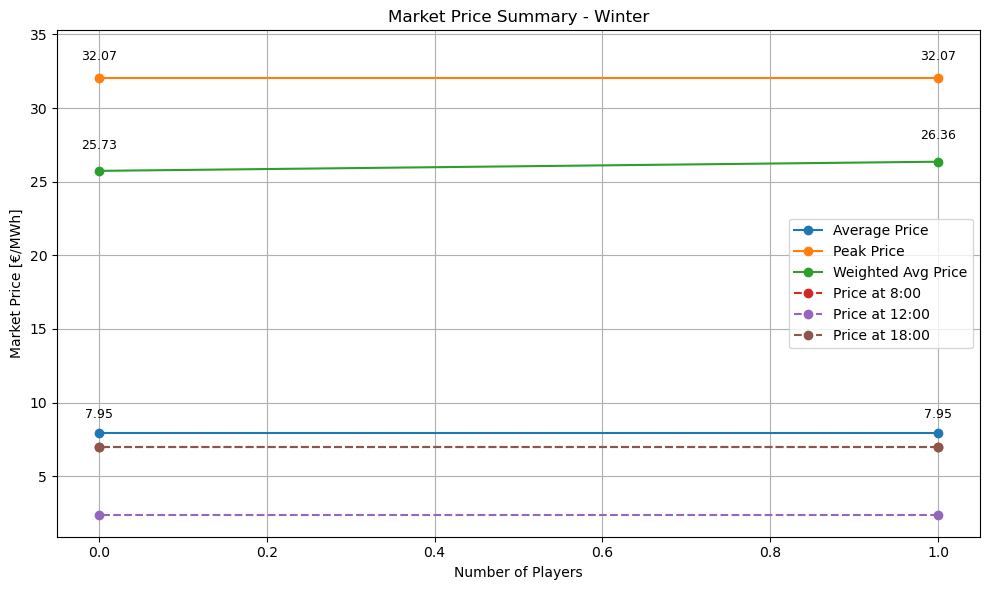

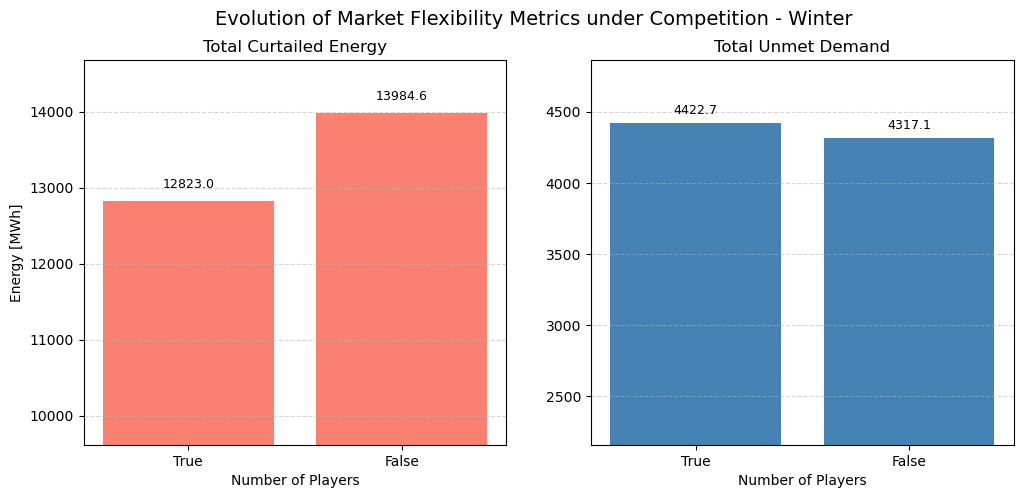

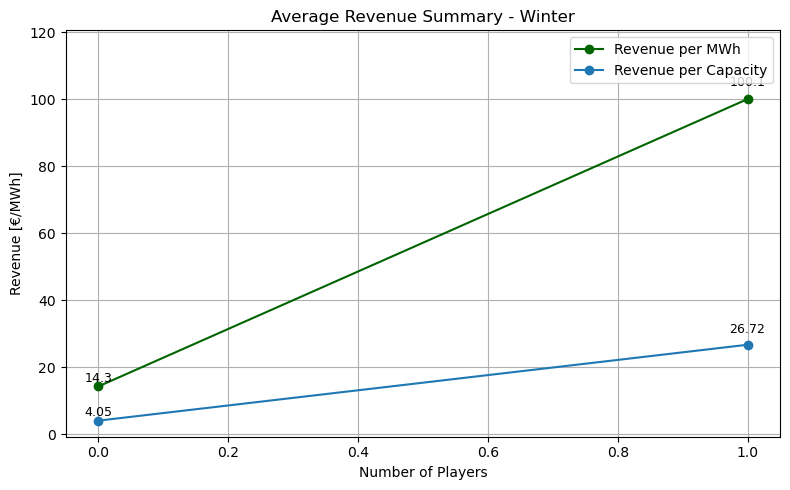

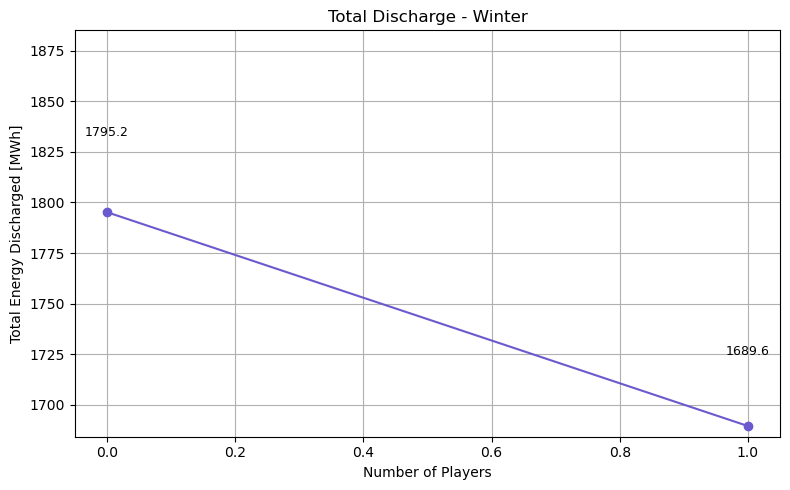

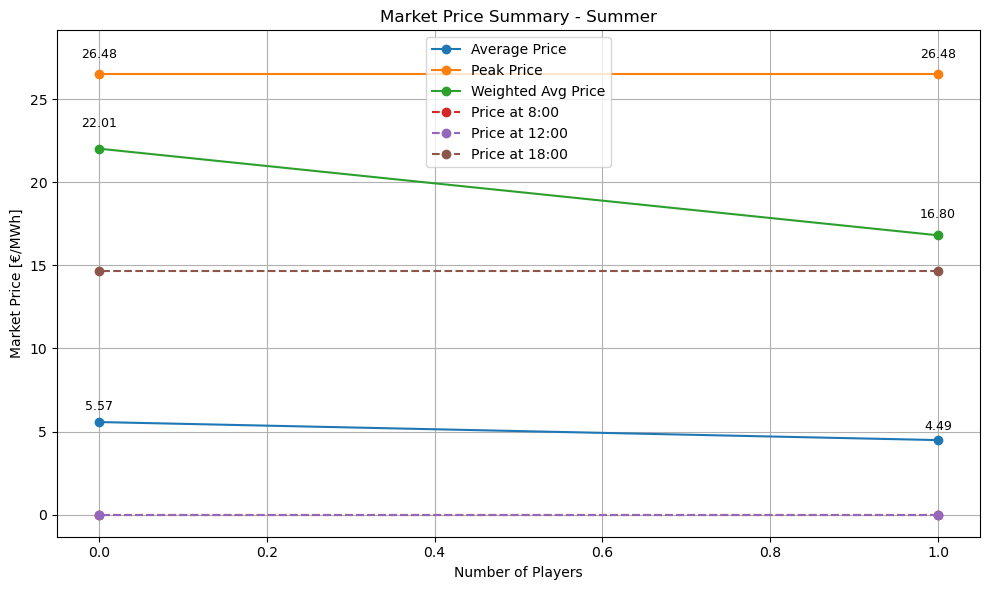

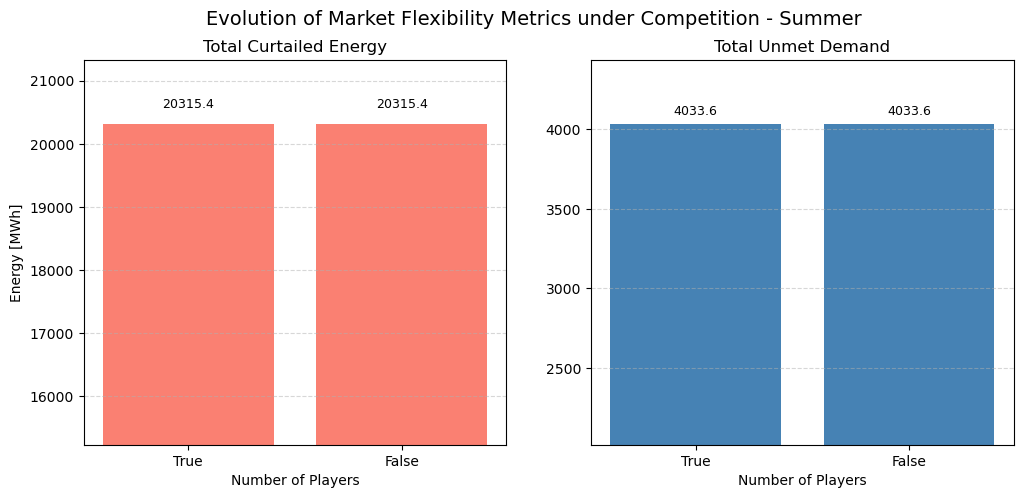

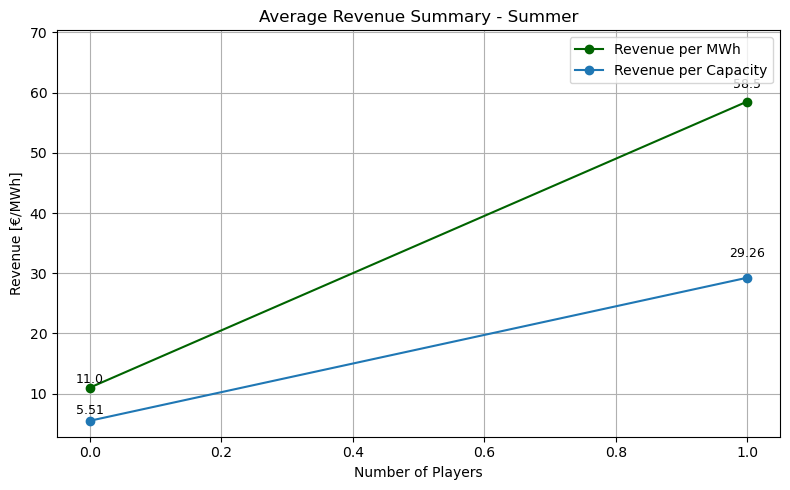

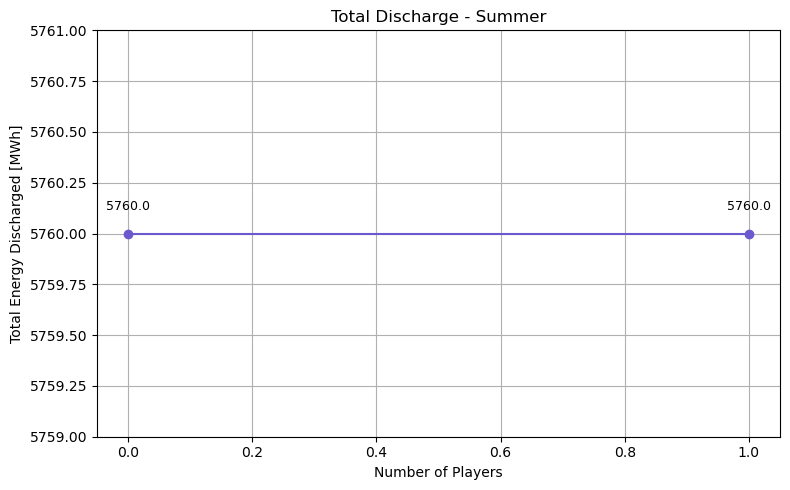

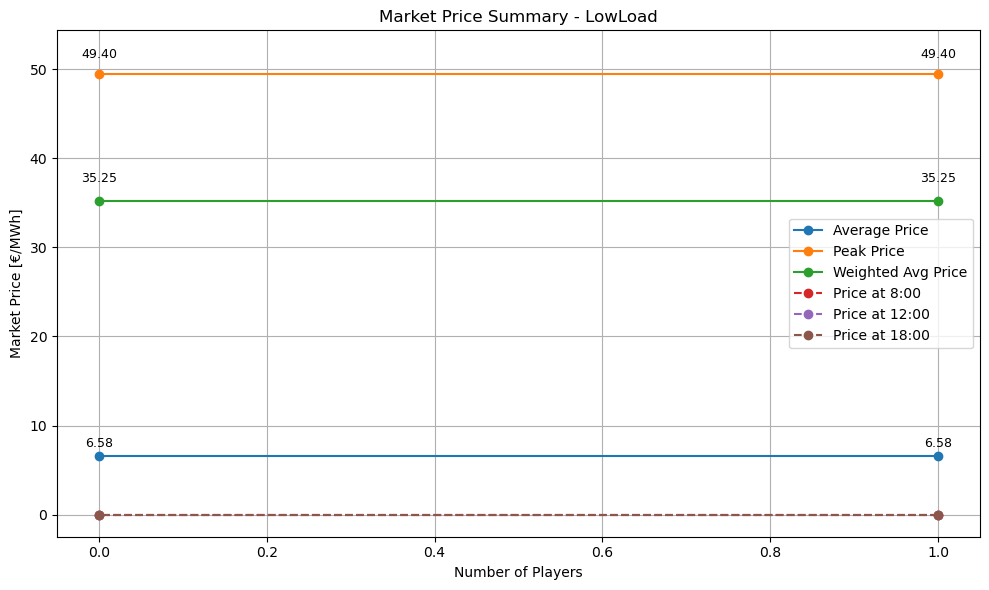

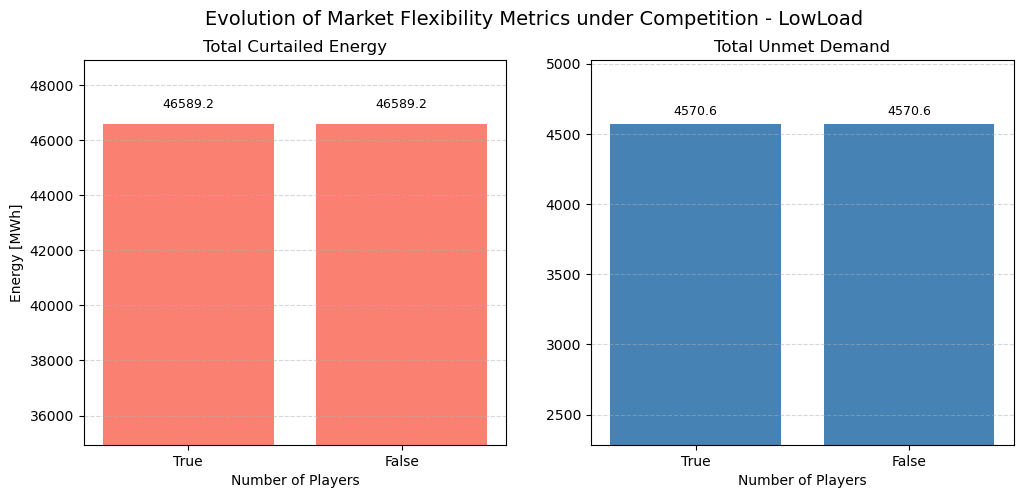

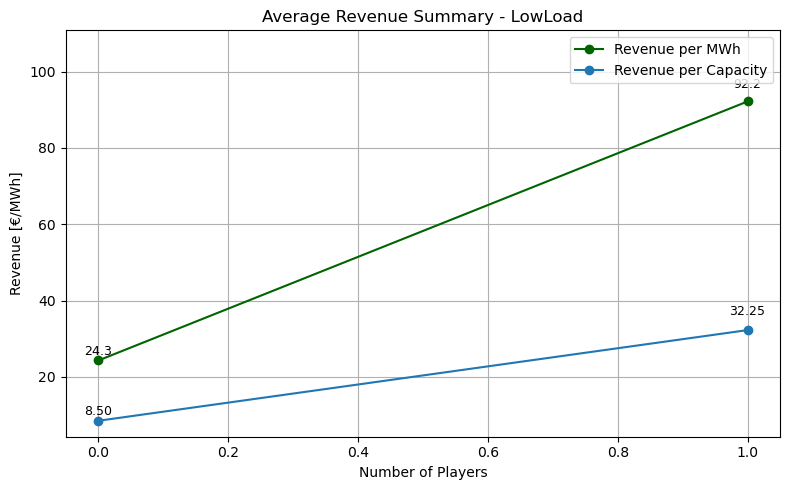

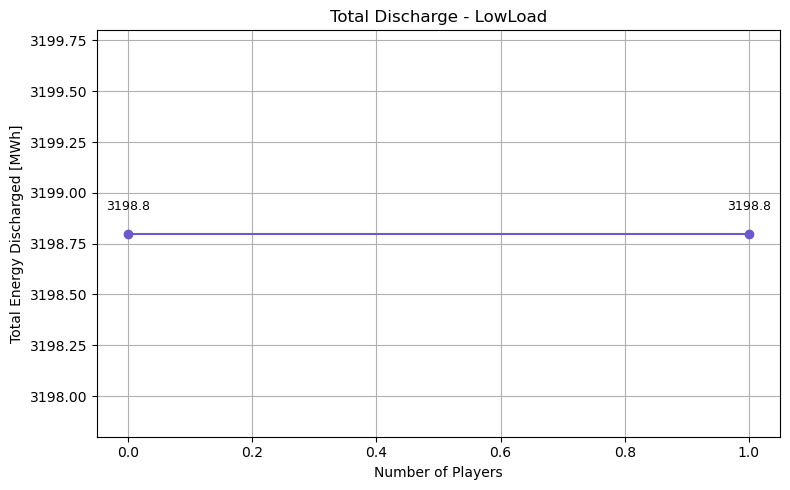

In [15]:
# seasons_plots = ["Winter"]
seasons_plots = seasons

for season in seasons_plots:
    plot_market_price_summary(results_reserve, season, player_counts=[True, False], save=SAVE_FIGS)
    # plot_stacked_welfare(results_reserve, season, player_counts=[True, False], save=SAVE_FIGS)
    plot_curtailment_and_unmet_subplots(results_reserve, season, player_counts=[True, False], save=SAVE_FIGS)
    plot_revenue_per_mwh(results_reserve, season, player_counts=[True, False], save=SAVE_FIGS)
    plot_total_discharge(results_reserve, season, player_counts=[True, False], save=SAVE_FIGS)